# Evaluate models

In [2]:
%load_ext autoreload
%autoreload 2
from capstone_libraries import *
import char_classification_models

In [3]:
plt.style.use('bmh')
sns.set(font_scale=1.5)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Get data

In [4]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('marc-dsi13')

In [5]:
machine = 'mac'

config_file = 'config.cfg'
config = configparser.ConfigParser()
config.read(config_file)

data_dir = config.get('directories',f'local_project_dir_{machine}')
data_dir = os.path.join(*ast.literal_eval(data_dir))

['config.cfg']

In [6]:
filename = 'data.pkl'
key = pj('capstone-data', filename)
try:
    bucket.download_file(key, pj(data_dir, 'ncvo_data', filename))
except botocore.exceptions.ClientError as e:
    if e.response['Error']['Code'] == "404":
        print("The object does not exist.")
    else:
        raise

In [7]:
with open(pj(data_dir, 'ncvo_data', filename),'rb') as f:
    data = pkl.load(f)

## Load models

Set up S3

In [8]:
def get_model_from_s3(filename):
    key = pj('capstone-data', filename)
    try:
        with tempfile.TemporaryFile() as fp:
            bucket.download_fileobj(key, fp)
            fp.seek(0)
            model = joblib.load(fp)
    except botocore.exceptions.ClientError as e:
        if e.response['Error']['Code'] == "404":
            print("The object does not exist.")
        else:
            raise
    return model

In [9]:
def train_test_setup(data):
    data_copy = data.copy()
    y = data_copy.pop('icnpo')
    X = data_copy
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=1)
    
    return X_train, X_test, y_train, y_test

In [10]:
# split data
X_train, X_test, y_train, y_test = train_test_setup(data)

### KNN

In [13]:
knn = get_model_from_s3('gridsearch_knn_2020_08_26_18_17.jlib')

In [14]:
knn.best_score_

0.5411165789209781

In [15]:
y_preds = knn.predict(X_test)

In [16]:
def plot_confusion_matrix_(conf_mat, class_labels, dec_place=0):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(conf_mat,
                yticklabels=class_labels,
                xticklabels=class_labels, 
                fmt=f'.{dec_place}f', annot=True, cmap= 'coolwarm'
               )
    plt.tight_layout()
    plt.savefig(pj('..','resources','knn_score_54.png'))
    plt.show();

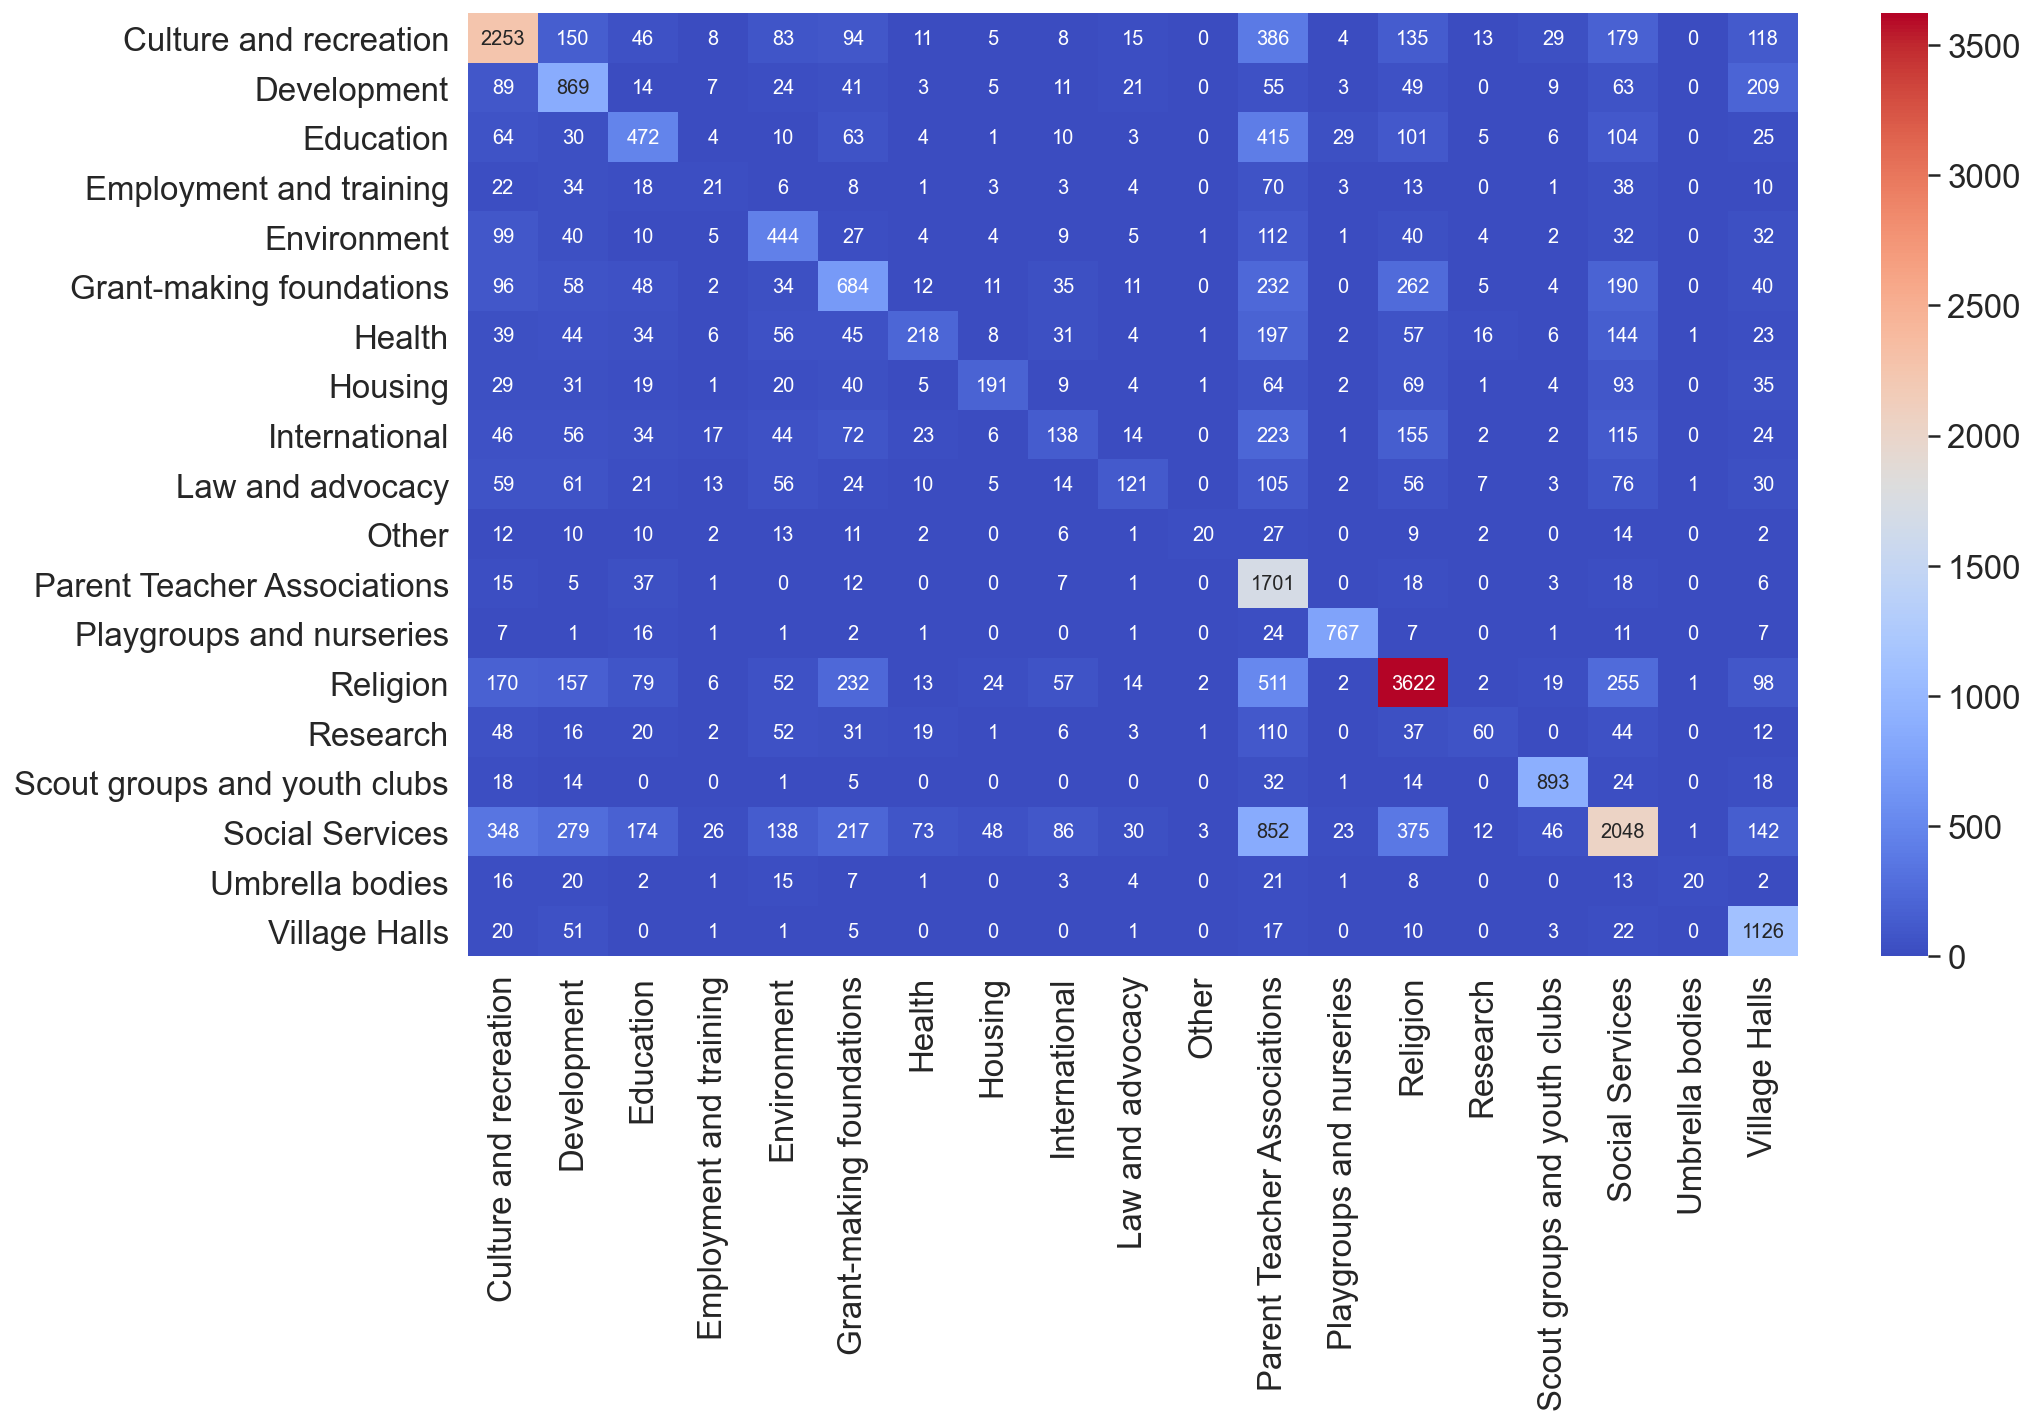

In [17]:
conf_mat = confusion_matrix(y_test, y_preds, labels=knn.classes_)
plot_confusion_matrix_(conf_mat, knn.classes_)

In [18]:
print(classification_report(y_test, y_preds))

                              precision    recall  f1-score   support

      Culture and recreation       0.65      0.64      0.64      3537
                 Development       0.45      0.59      0.51      1472
                   Education       0.45      0.35      0.39      1346
     Employment and training       0.17      0.08      0.11       255
                 Environment       0.42      0.51      0.46       871
    Grant-making foundations       0.42      0.40      0.41      1724
                      Health       0.55      0.23      0.33       932
                     Housing       0.61      0.31      0.41       618
               International       0.32      0.14      0.20       972
            Law and advocacy       0.47      0.18      0.26       664
                       Other       0.69      0.14      0.24       141
 Parent Teacher Associations       0.33      0.93      0.49      1824
    Playgroups and nurseries       0.91      0.91      0.91       847
                   

In [19]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette(
    "husl", len(y_test.unique())))

In [20]:
probabilities = knn.predict_proba(X_test)

In [21]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

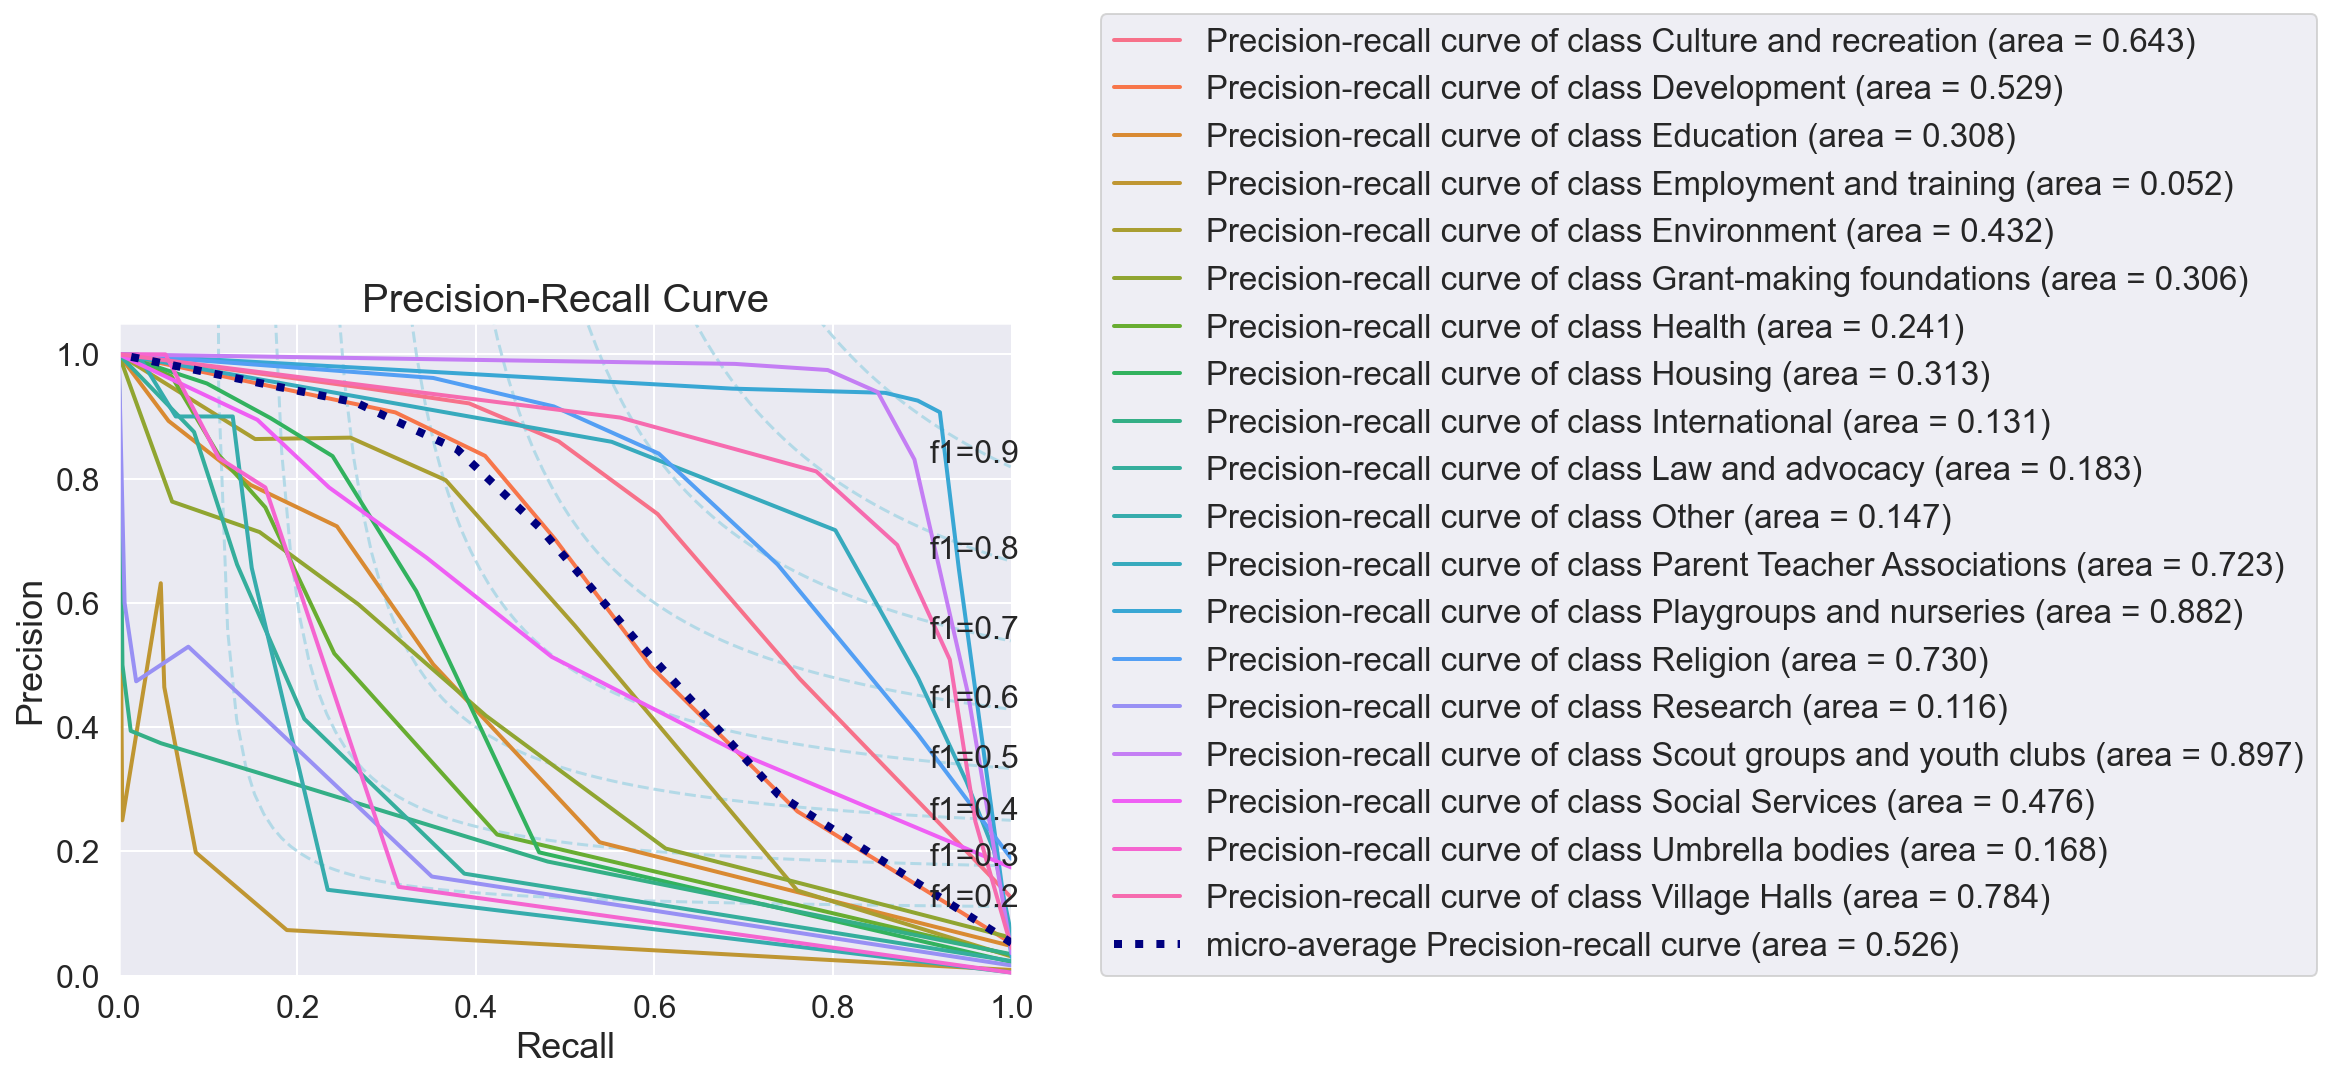

In [22]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities,
                                    plot_micro=True,
                                    title_fontsize=20, text_fontsize=16,
                                    cmap=cmap,
                                    ax=ax
                                    )
plt.savefig(pj('..','resources','knn_prec_rec.png'))
ax.legend(loc=[1.1, 0])
plt.show();

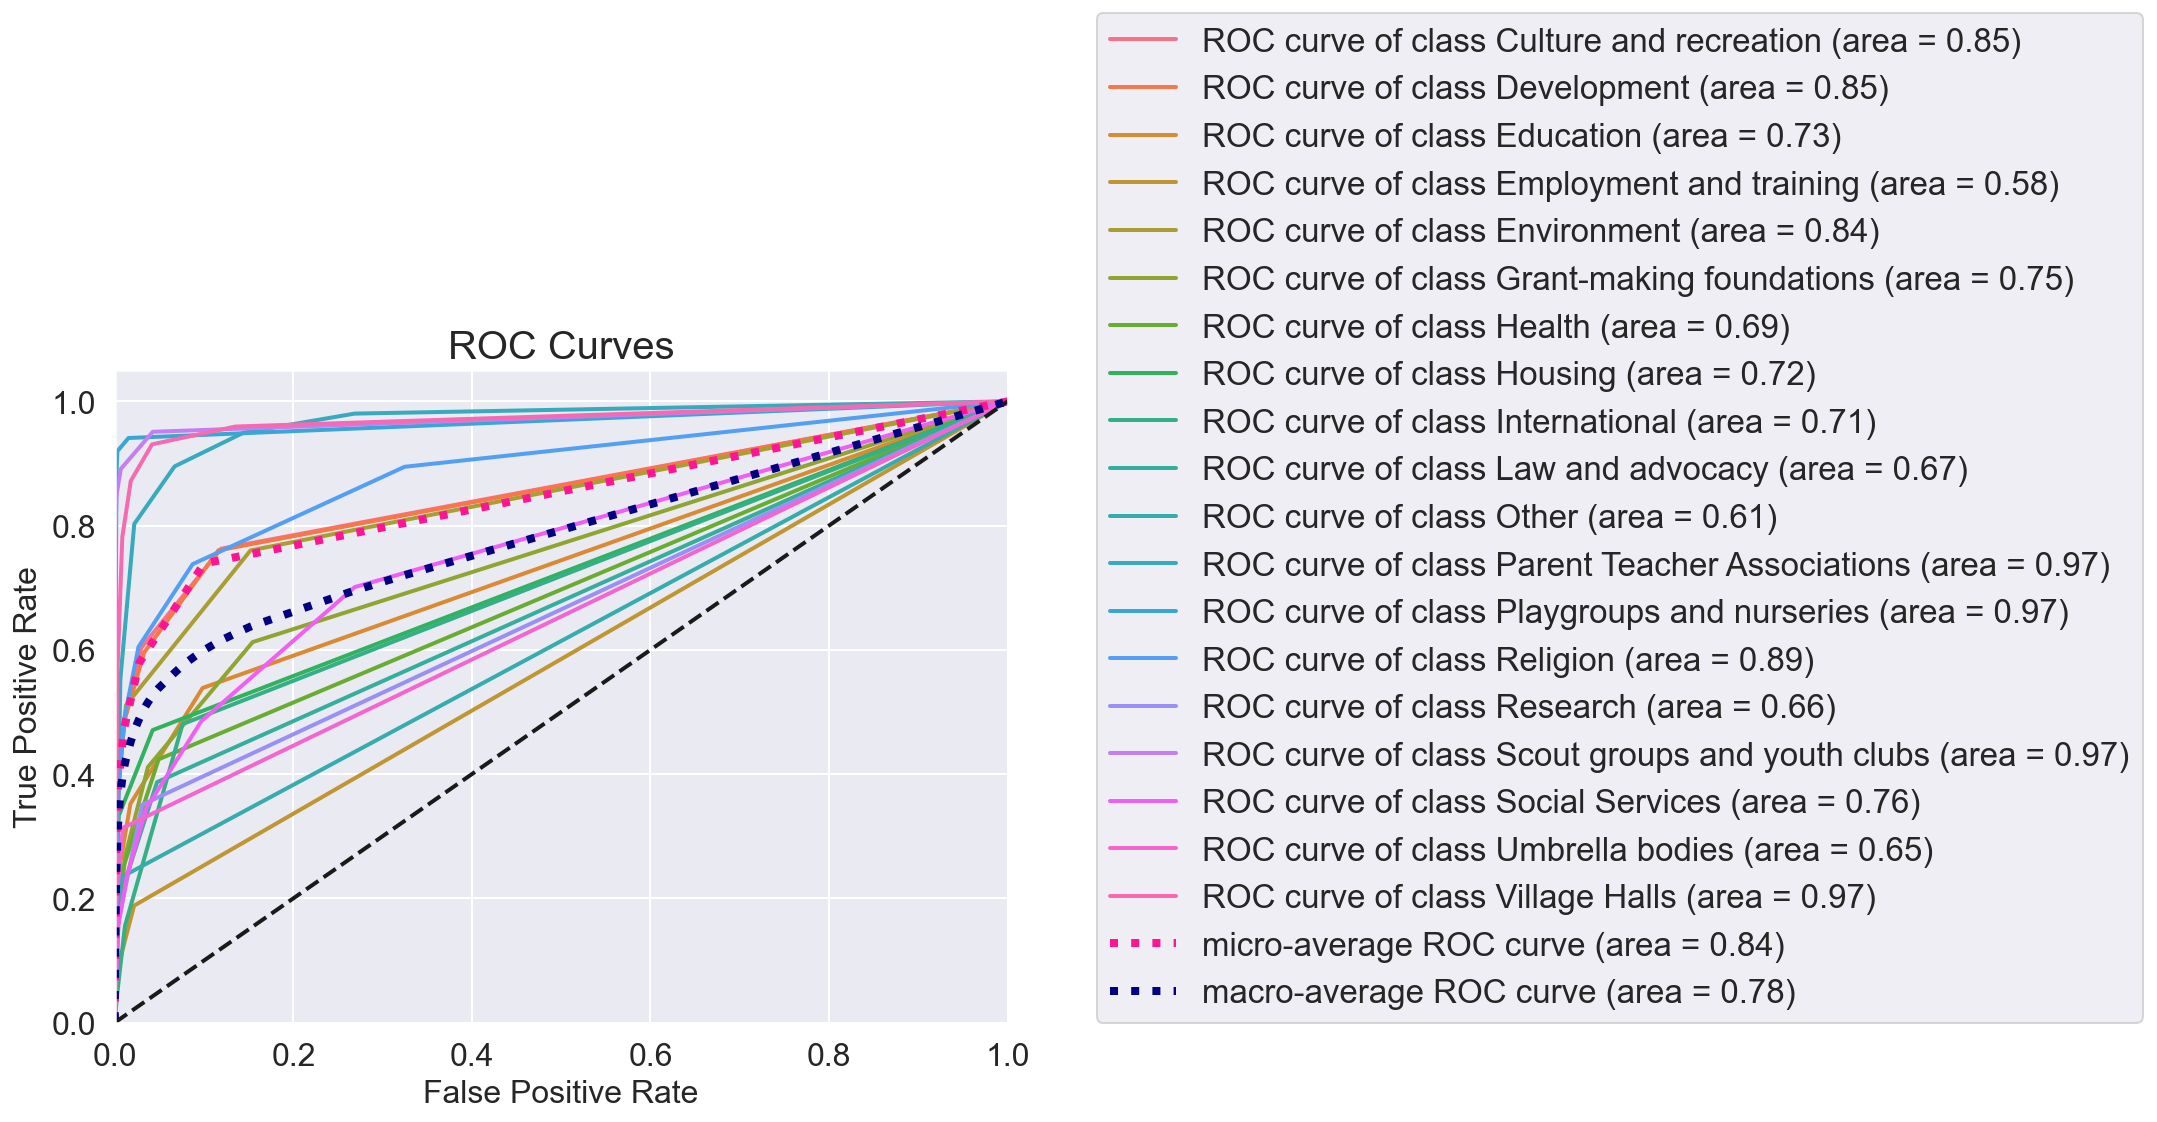

In [23]:
fig, ax = plt.subplots(figsize=(8, 6))
skplt.metrics.plot_roc(y_test, probabilities,
                       plot_micro=True, plot_macro=True,
                       title_fontsize=20, text_fontsize=16,
                       figsize=(8, 6), cmap=cmap, ax=ax)
plt.savefig(pj('..','resources','knn_roc.png'))
ax.legend(loc=[1.1, 0])
plt.show();

### Multi-layer Perceptron

In [24]:
mlp = get_model_from_s3('default_mlp_2020_08_26_21_27.jlib')

In [25]:
y_preds = mlp.predict(X_test)

In [26]:
def plot_confusion_matrix_(conf_mat, class_labels, dec_place=0):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(conf_mat,
                yticklabels=class_labels,
                xticklabels=class_labels, 
                fmt=f'.{dec_place}f', annot=True, cmap= 'coolwarm'
               )
    plt.tight_layout()
    plt.savefig(pj('..','resources','mlp_score_67.png'))
    plt.show();

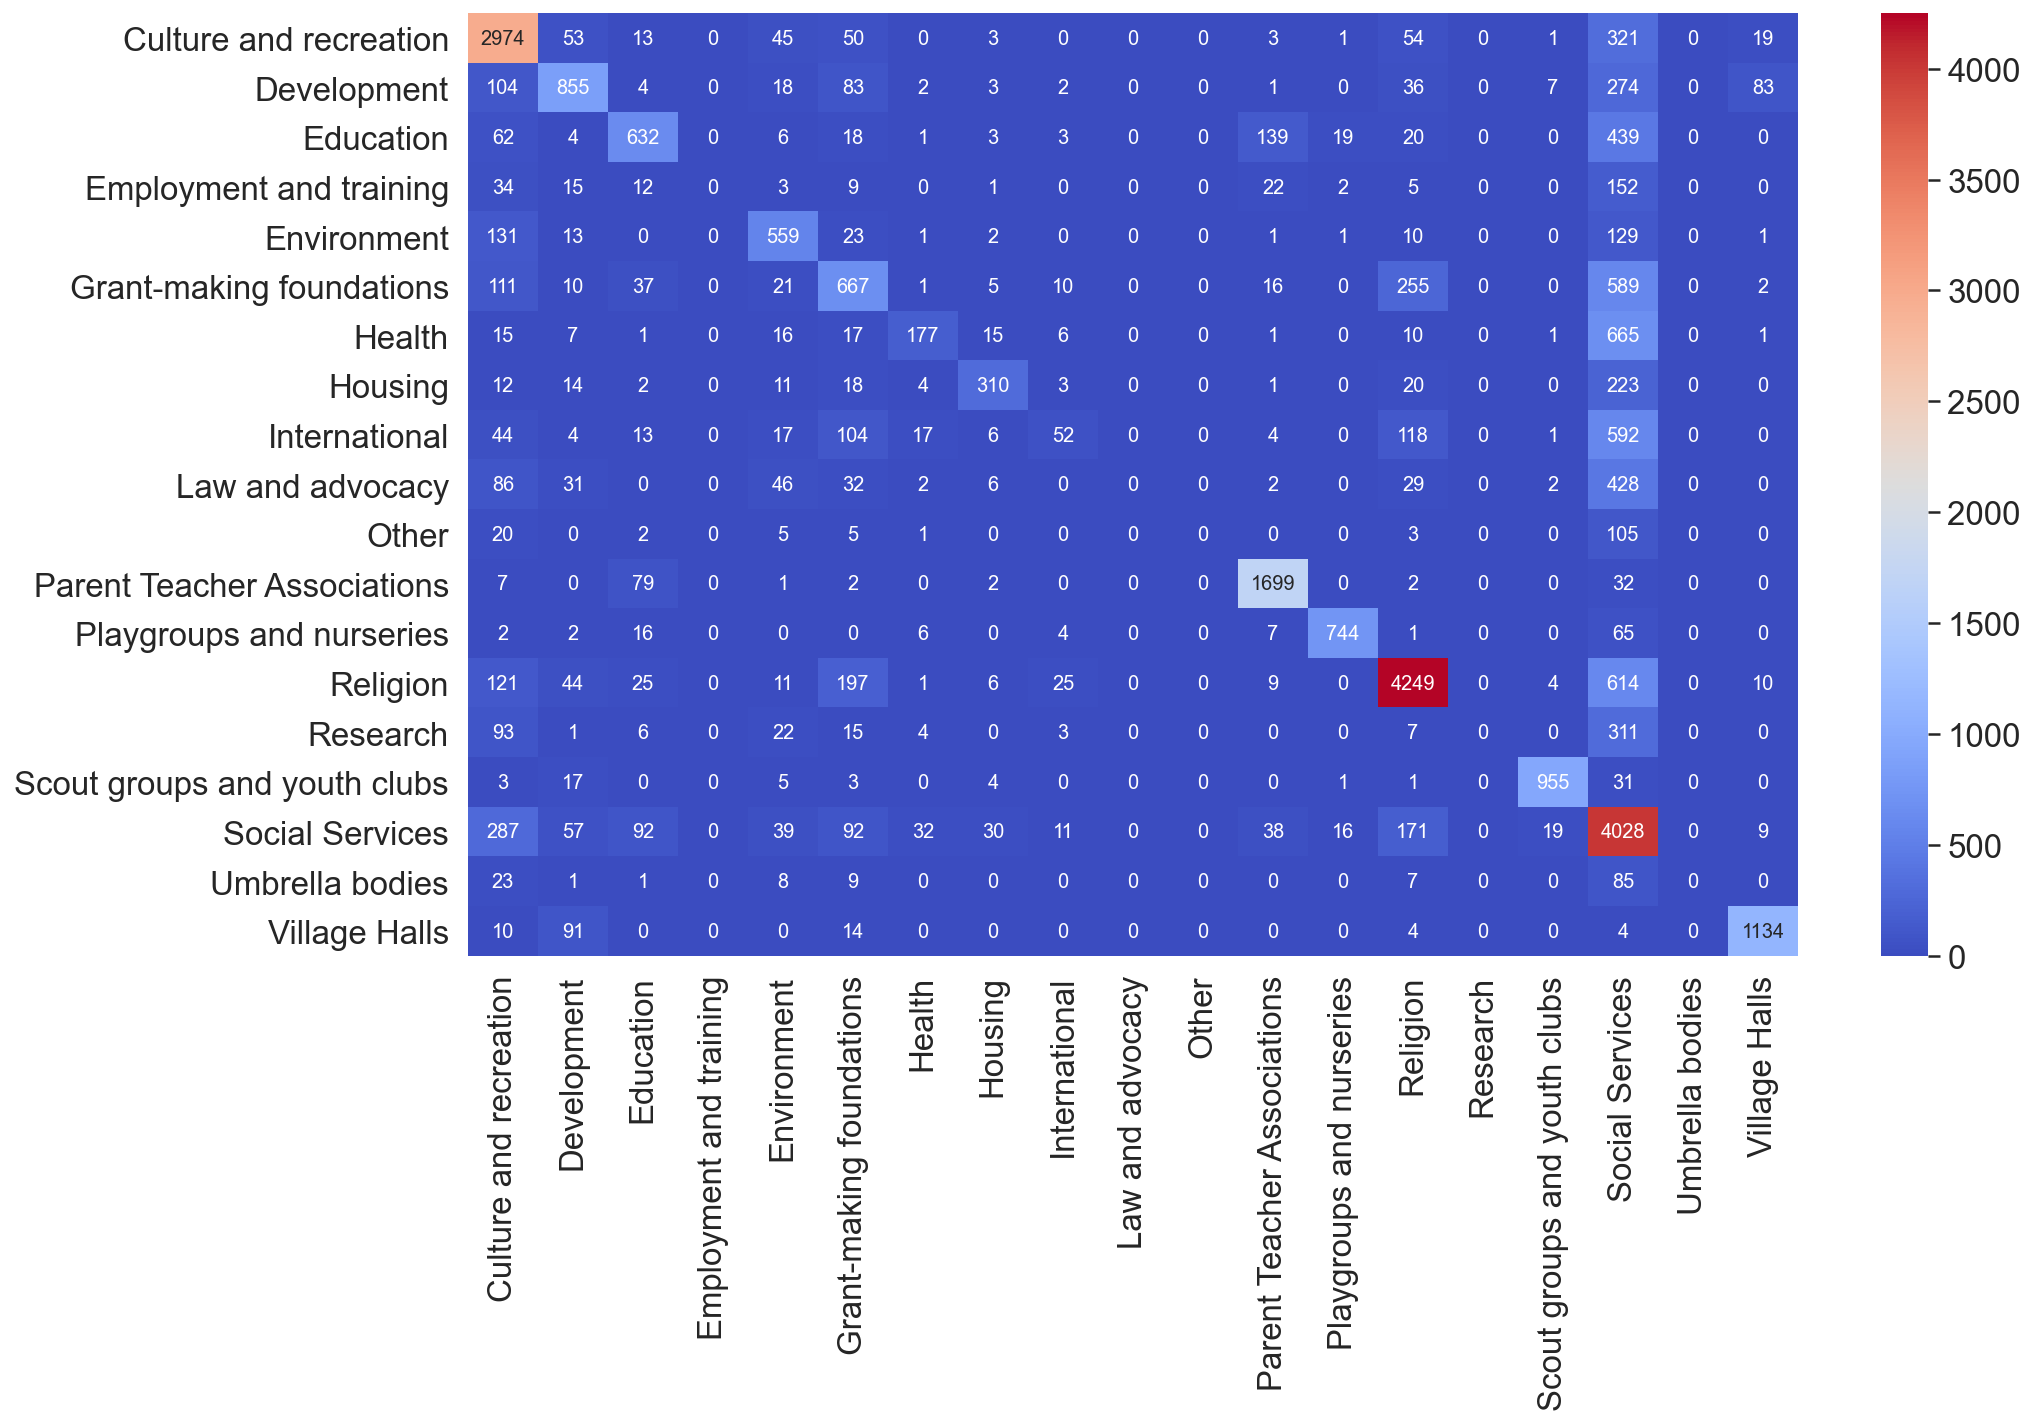

In [27]:
conf_mat = confusion_matrix(y_test, y_preds, labels=mlp.classes_)
plot_confusion_matrix_(conf_mat, mlp.classes_)

In [28]:
print(classification_report(y_test, y_preds))

/Users/marclawson/opt/anaconda3/envs/py3_ga/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                              precision    recall  f1-score   support

      Culture and recreation       0.72      0.84      0.77      3537
                 Development       0.70      0.58      0.64      1472
                   Education       0.68      0.47      0.55      1346
     Employment and training       0.00      0.00      0.00       255
                 Environment       0.67      0.64      0.66       871
    Grant-making foundations       0.49      0.39      0.43      1724
                      Health       0.71      0.19      0.30       932
                     Housing       0.78      0.50      0.61       618
               International       0.44      0.05      0.10       972
            Law and advocacy       0.00      0.00      0.00       664
                       Other       0.00      0.00      0.00       141
 Parent Teacher Associations       0.87      0.93      0.90      1824
    Playgroups and nurseries       0.95      0.88      0.91       847
                   

In [29]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette(
    "husl", len(y_test.unique())))

In [30]:
probabilities = mlp.predict_proba(X_test)

In [31]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

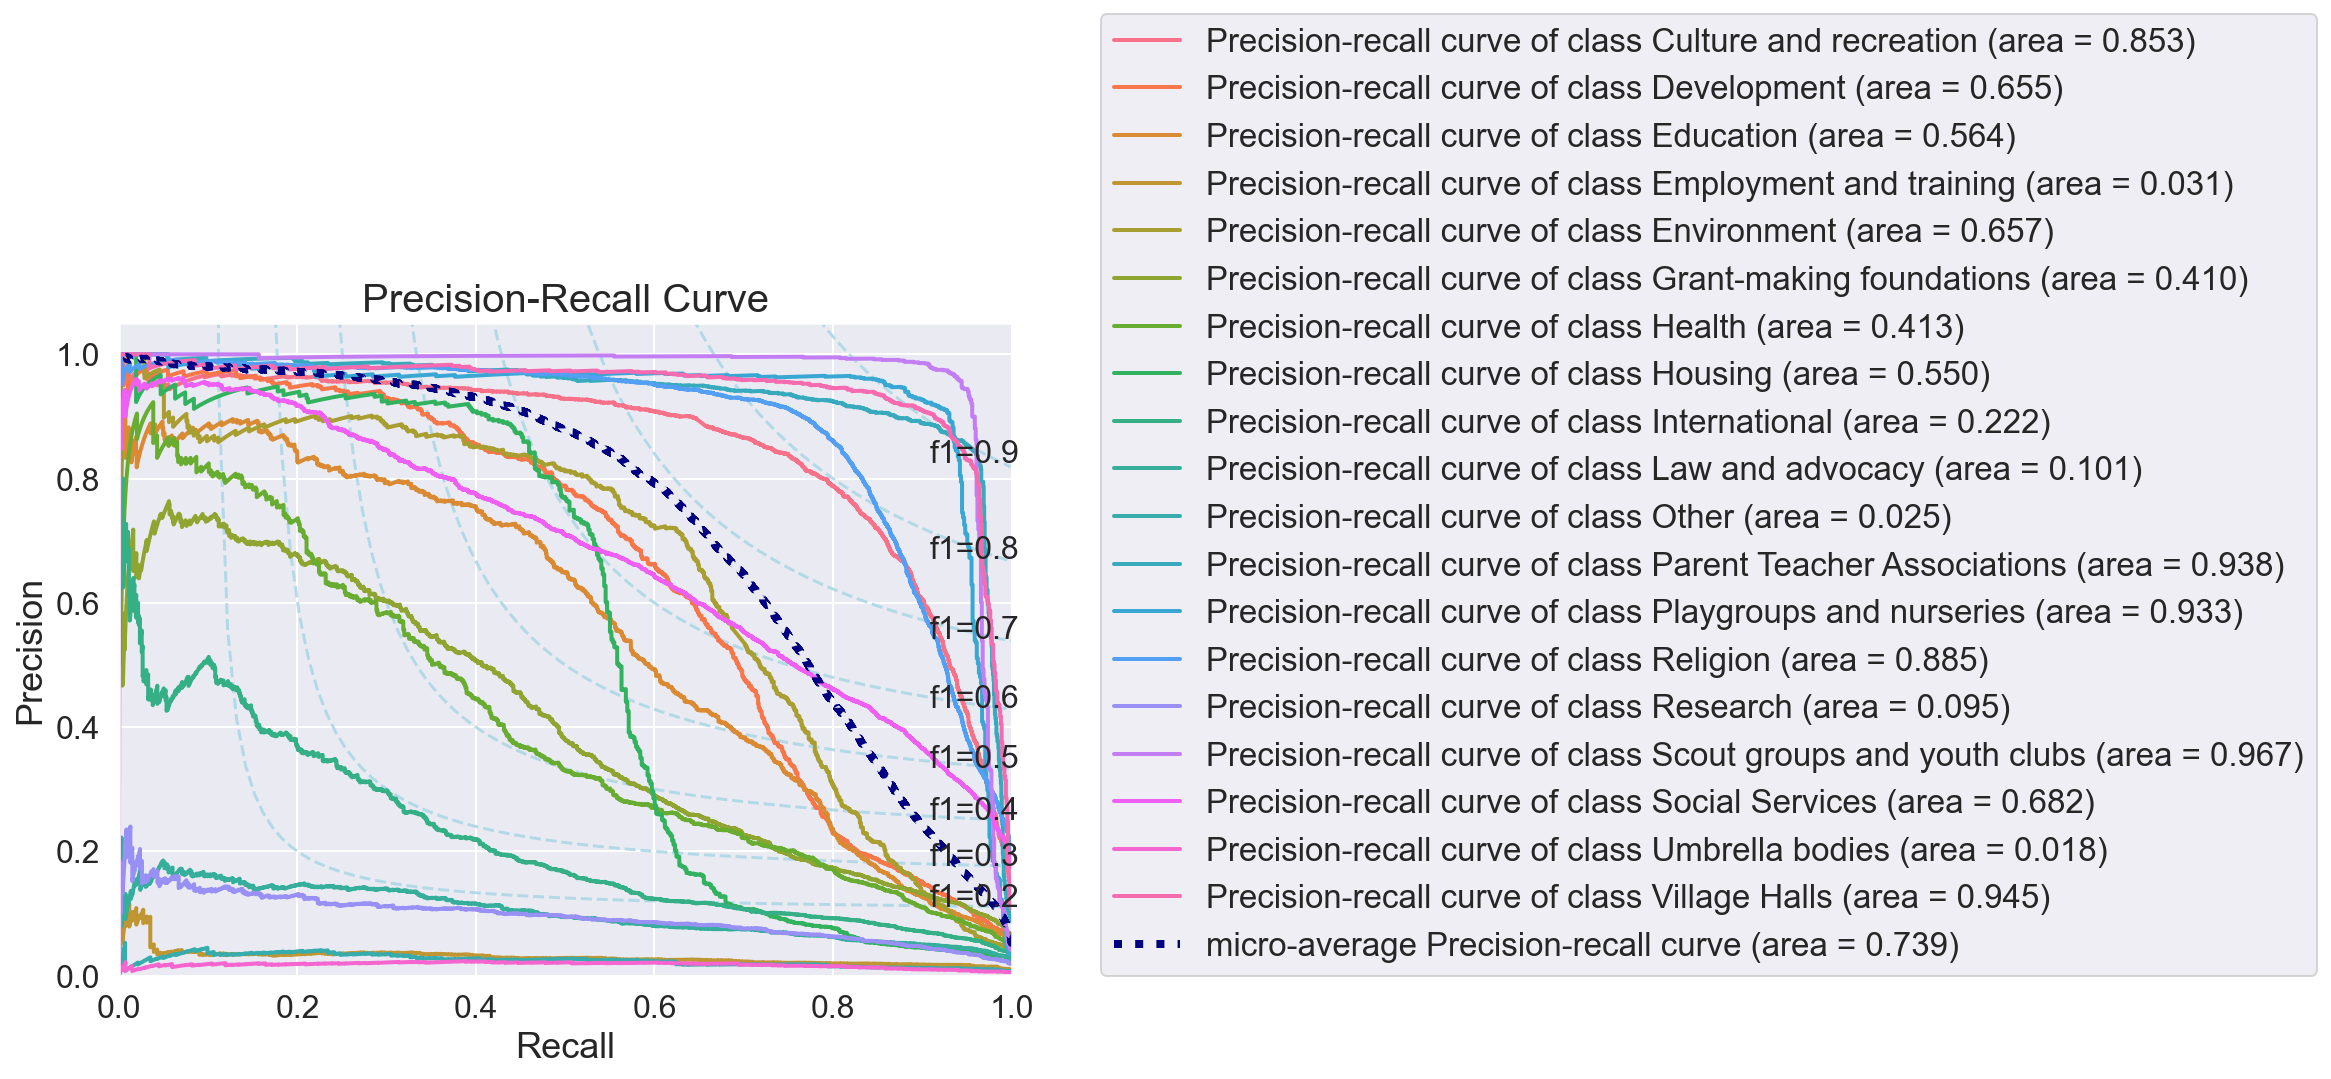

In [32]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities,
                                    plot_micro=True,
                                    title_fontsize=20, text_fontsize=16,
                                    cmap=cmap,
                                    ax=ax
                                    )

plt.savefig(pj('..','resources','mlp_prec_rec.png'))
ax.legend(loc=[1.1, 0])
plt.show();

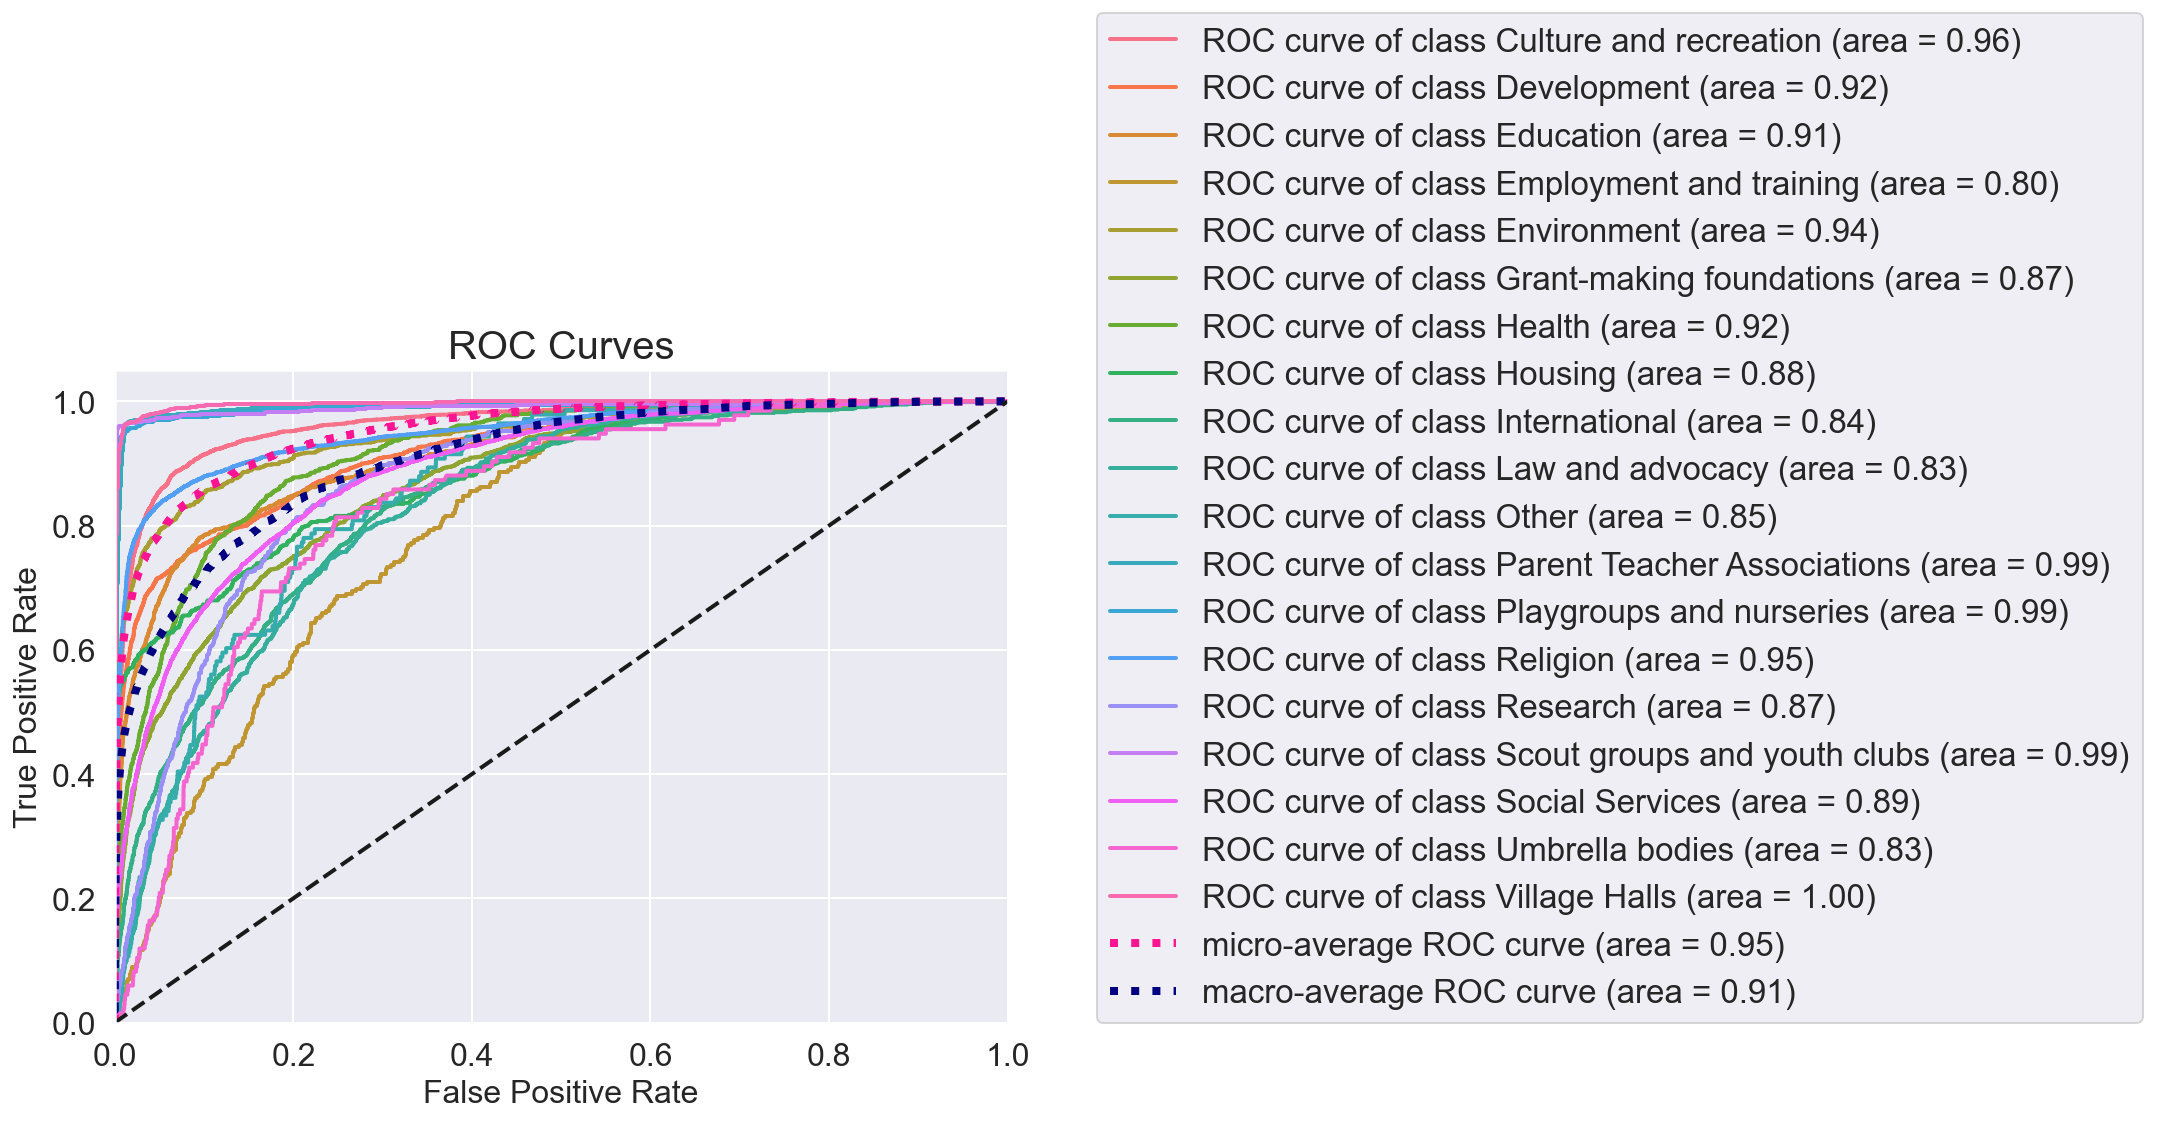

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
skplt.metrics.plot_roc(y_test, probabilities,
                       plot_micro=True, plot_macro=True,
                       title_fontsize=20, text_fontsize=16,
                       figsize=(8, 6), cmap=cmap, ax=ax)
plt.savefig(pj('..','resources','mlp_roc.png'))
ax.legend(loc=[1.1, 0])
plt.show();

### CART (Bagging)

In [34]:
cart_bc = get_model_from_s3('default_cart_bc_2020_08_26_22_06.jlib')

In [35]:
y_preds = cart_bc.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.2s remaining:    6.7s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    2.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    2.3s remaining:    2.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    2.3s remaining:    1.4s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    2.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.3s finished


In [36]:
def plot_confusion_matrix_(conf_mat, class_labels, dec_place=0):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(conf_mat,
                yticklabels=class_labels,
                xticklabels=class_labels, 
                fmt=f'.{dec_place}f', annot=True, cmap= 'coolwarm'
               )
    plt.tight_layout()
    plt.savefig(pj('..','resources','cart_bc_score_74.png'))
    plt.show();

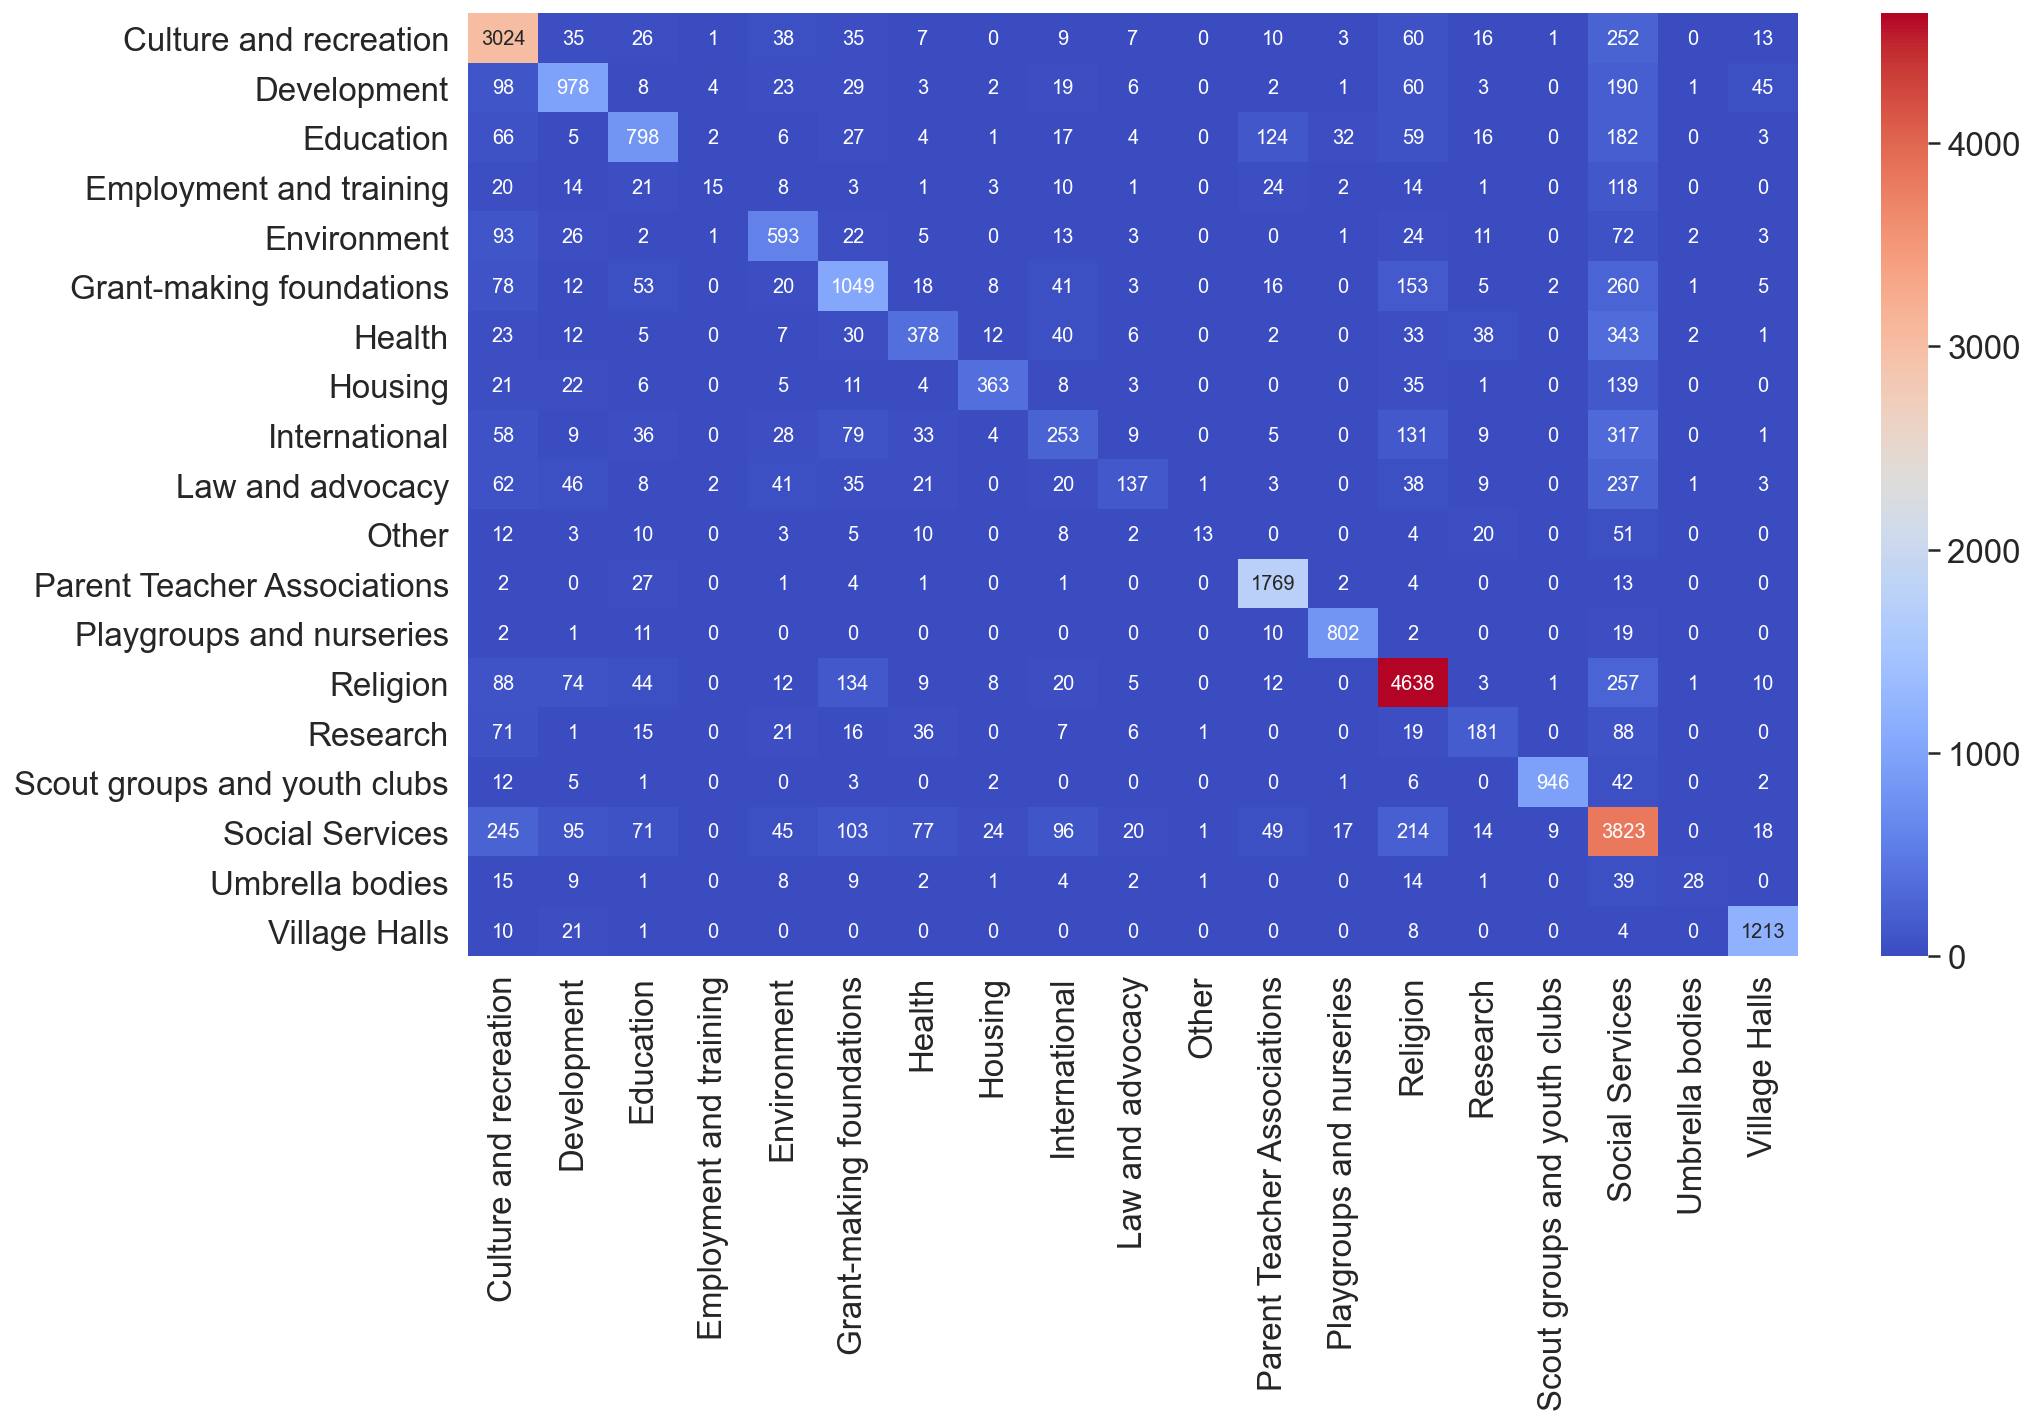

In [37]:
conf_mat = confusion_matrix(y_test, y_preds, labels=cart_bc.classes_)
plot_confusion_matrix_(conf_mat, cart_bc.classes_)

In [38]:
print(classification_report(y_test, y_preds))

                              precision    recall  f1-score   support

      Culture and recreation       0.76      0.85      0.80      3537
                 Development       0.71      0.66      0.69      1472
                   Education       0.70      0.59      0.64      1346
     Employment and training       0.60      0.06      0.11       255
                 Environment       0.69      0.68      0.69       871
    Grant-making foundations       0.66      0.61      0.63      1724
                      Health       0.62      0.41      0.49       932
                     Housing       0.85      0.59      0.69       618
               International       0.45      0.26      0.33       972
            Law and advocacy       0.64      0.21      0.31       664
                       Other       0.76      0.09      0.16       141
 Parent Teacher Associations       0.87      0.97      0.92      1824
    Playgroups and nurseries       0.93      0.95      0.94       847
                   

In [39]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette(
    "husl", len(y_test.unique())))

In [40]:
probabilities = cart_bc.predict_proba(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.3s remaining:    2.2s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.4s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished


In [41]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

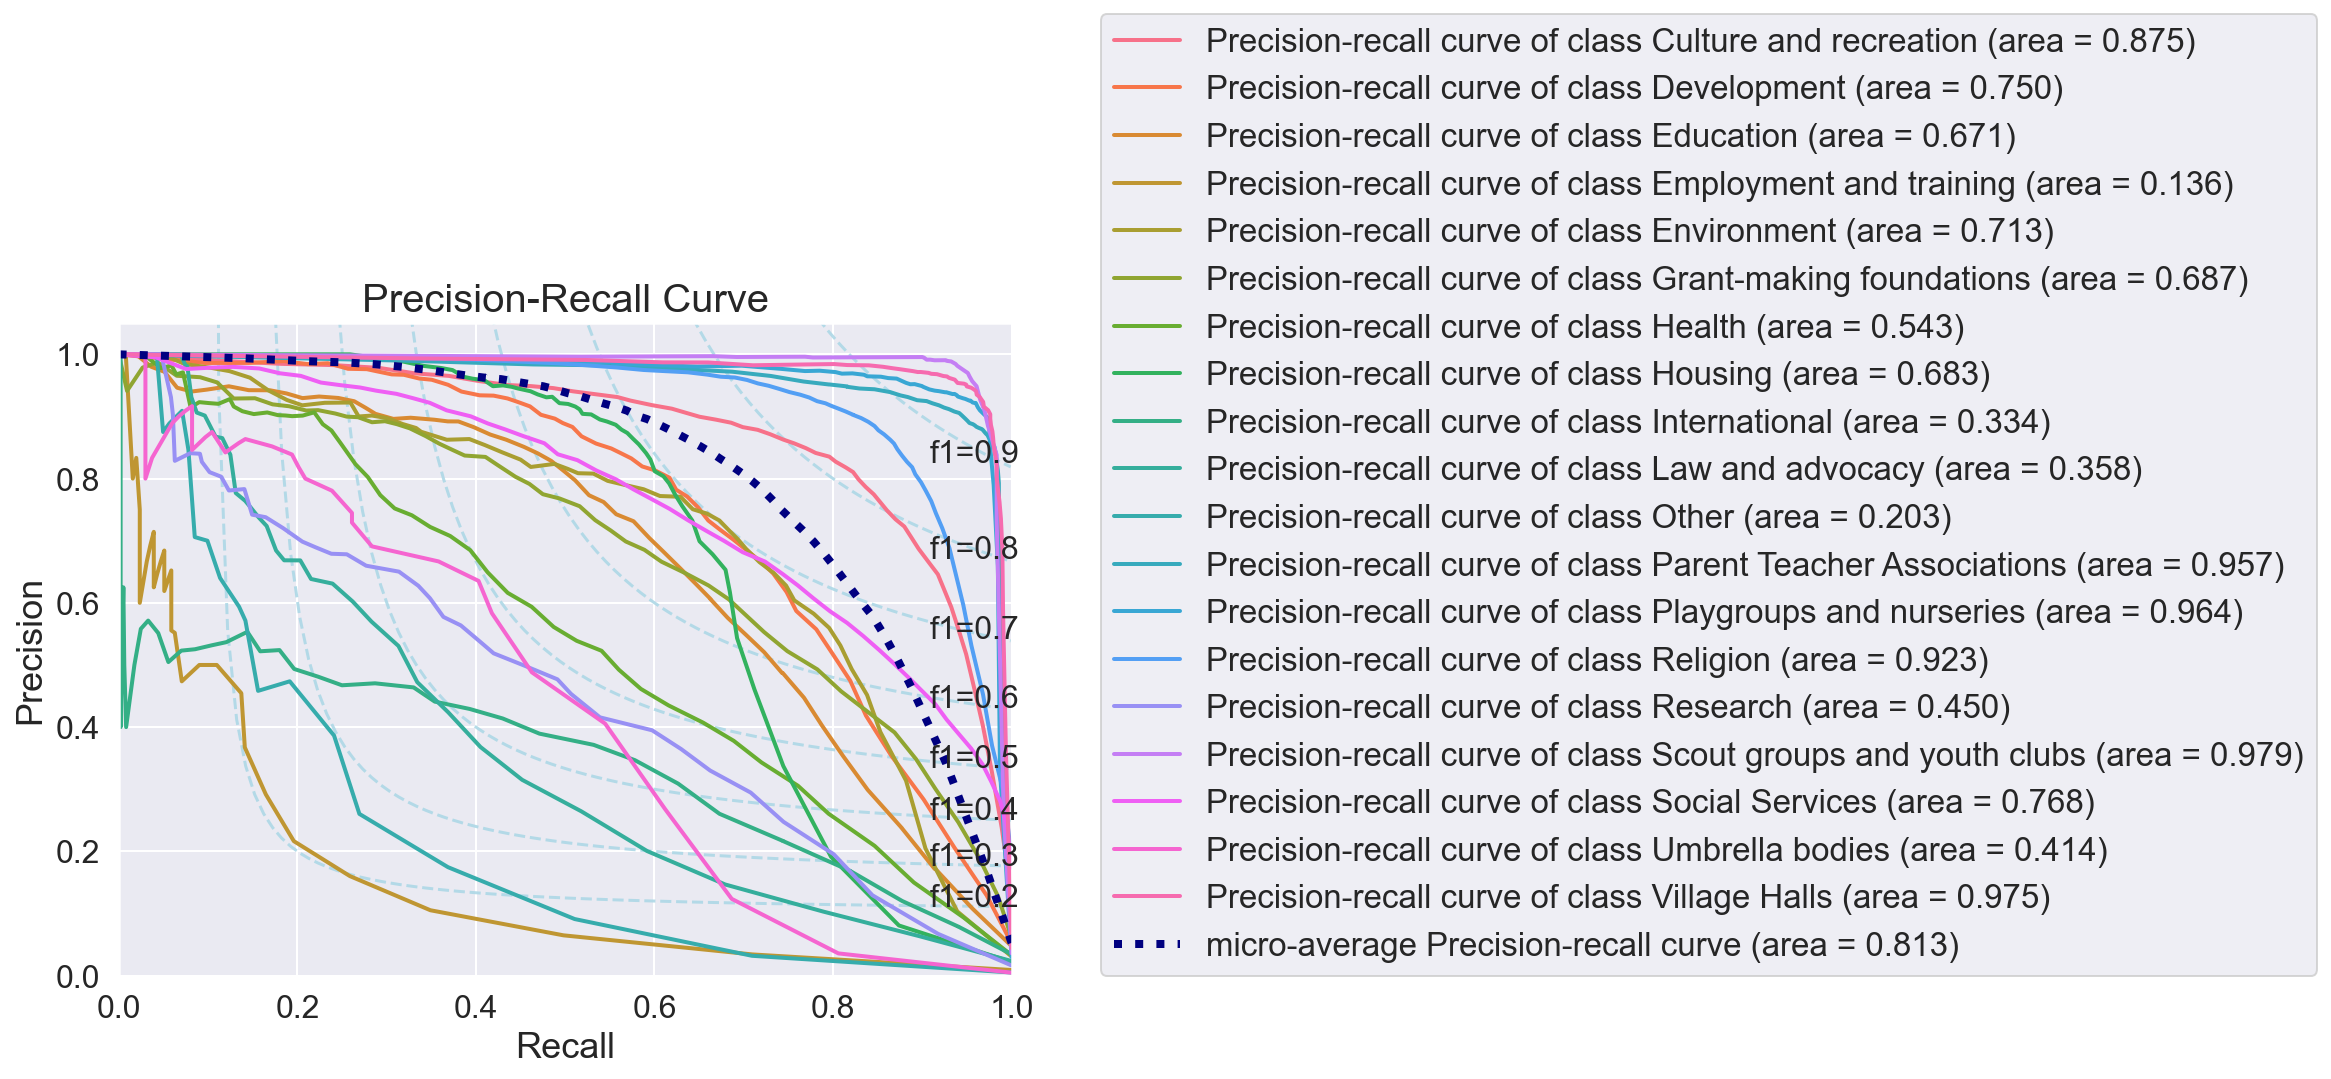

In [42]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities,
                                    plot_micro=True,
                                    title_fontsize=20, text_fontsize=16,
                                    cmap=cmap,
                                    ax=ax
                                    )

plt.savefig(pj('..','resources','cart_bc_prec_rec.png'))
ax.legend(loc=[1.1, 0])
plt.show();

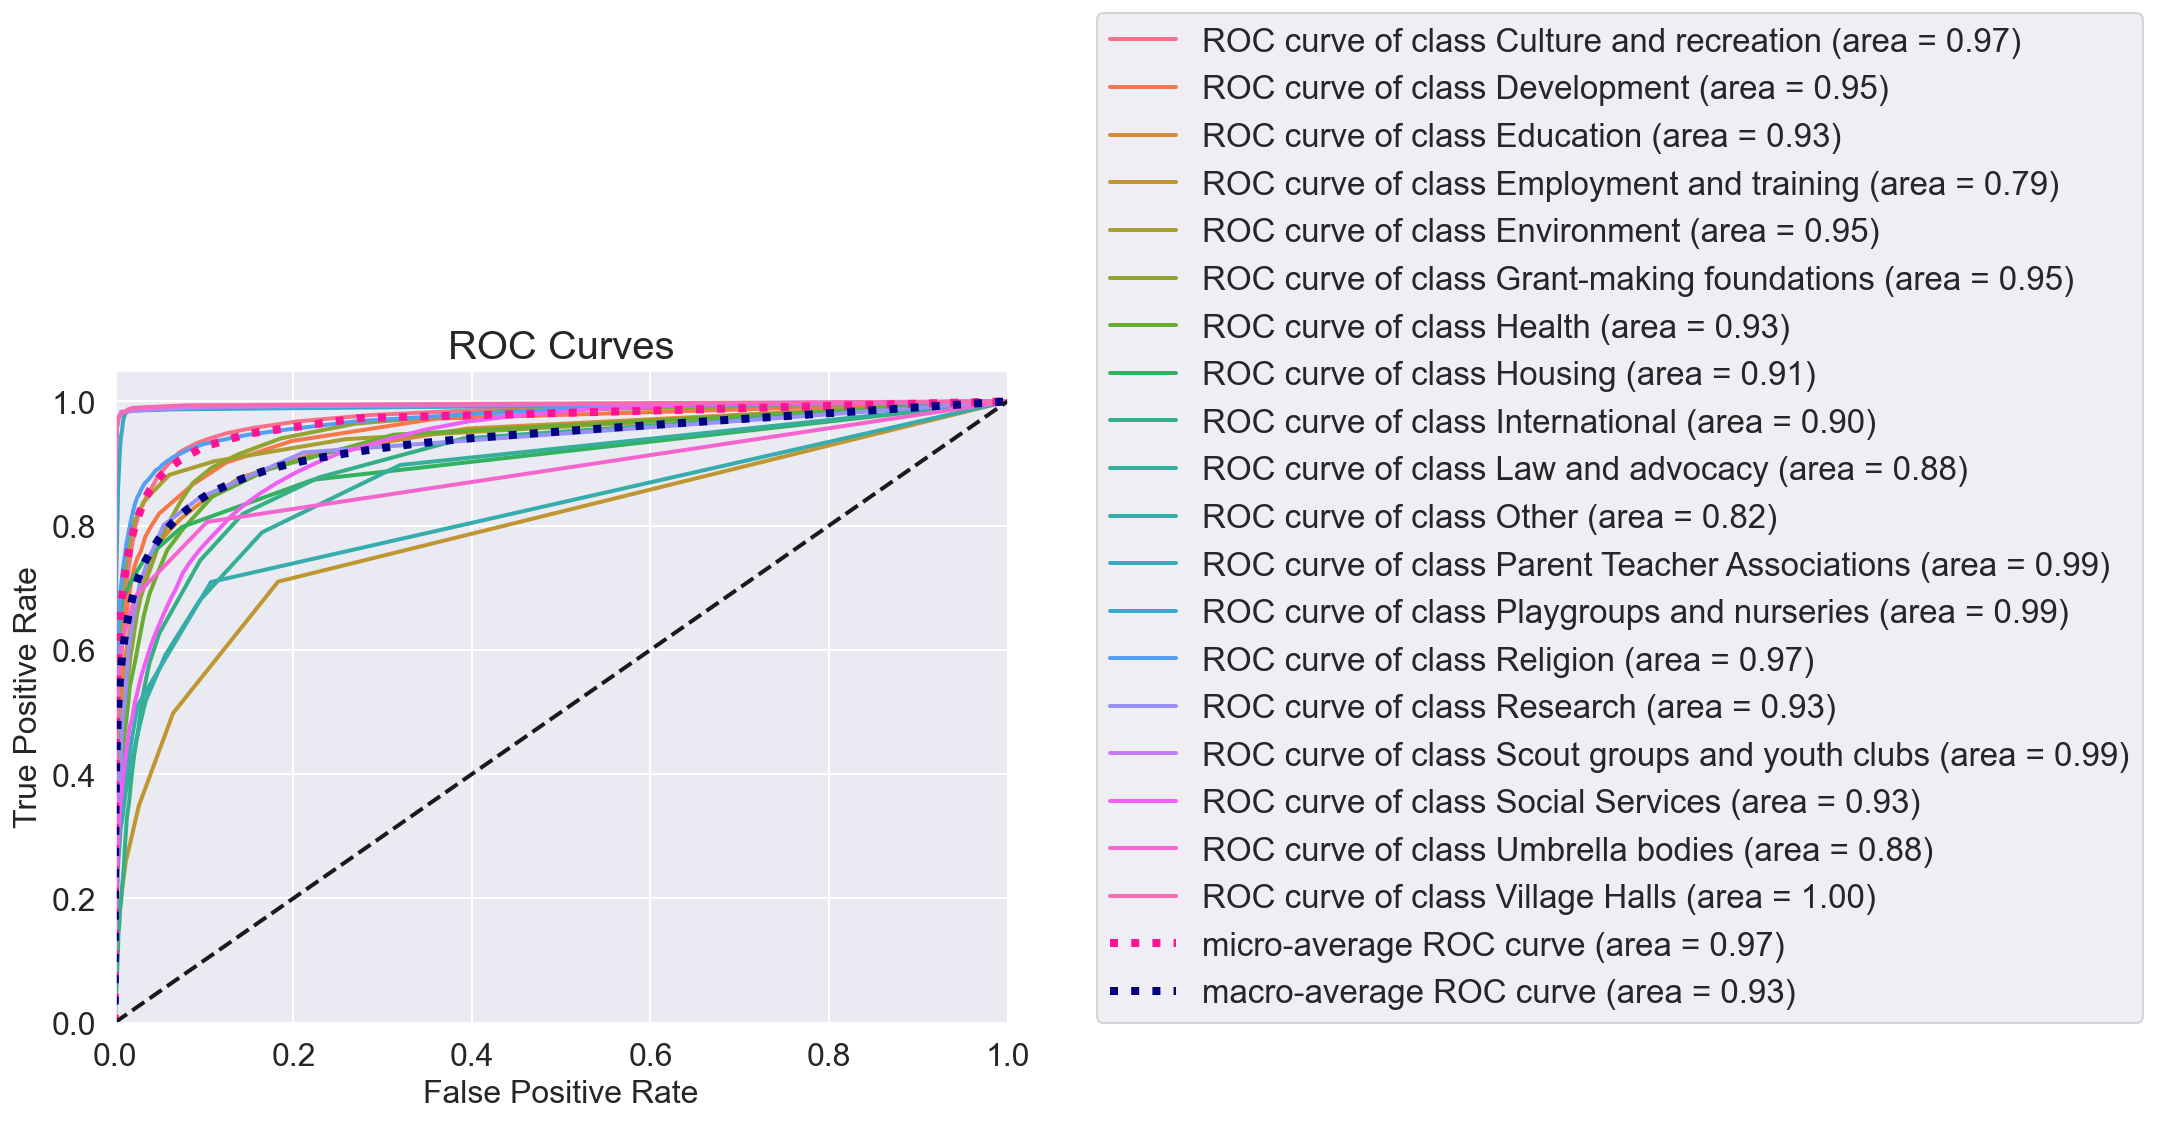

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
skplt.metrics.plot_roc(y_test, probabilities,
                       plot_micro=True, plot_macro=True,
                       title_fontsize=20, text_fontsize=16,
                       figsize=(8, 6), cmap=cmap, ax=ax)
plt.savefig(pj('..','resources','cart_bc_roc.png'))
ax.legend(loc=[1.1, 0])
plt.show();

In [ ]:
dot_data = StringIO()
export_graphviz(classifier,
                out_file=dot_data,
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=iris.feature_names
                )

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

Image(graph.create_png())

In [84]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score

In [95]:
THRESHOLD = 0.2
new_preds = np.where(probabilities[:,1] > THRESHOLD, 1, 0)

#pd.DataFrame(data=[accuracy_score(y_test, preds), recall_score(y_test, preds),
#                   precision_score(y_test, preds), roc_auc_score(y_test, preds)], 
#             index=["accuracy", "recall", "precision", "roc_auc_score"])

In [146]:
new_preds = []
for i in range(0, 19):
    print(i)
    new_preds.append((cart_bc.predict_proba(X_test)[:,i]>=0.2).astype(int))

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.2s remaining:    3.5s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.2s remaining:    2.0s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.4s

In [165]:
np.array(new_preds)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [169]:
pd.DataFrame(np.array(new_preds), index=[cart_bc.classes_])

0      1      2      3      4      5      6      \
Culture and recreation            0      0      0      0      0      0      1   
Development                       0      0      0      0      0      0      0   
Education                         0      0      0      0      0      0      0   
Employment and training           0      0      0      0      0      0      0   
Environment                       0      0      0      0      0      0      0   
Grant-making foundations          0      0      1      1      0      1      0   
Health                            0      0      0      0      0      0      0   
Housing                           0      0      0      0      0      0      0   
International                     0      0      0      0      0      0      0   
Law and advocacy                  0      0      0      0      0      0      0   
Other                             0      0      0      0      0      0      0   
Parent Teacher Associations       0      1      0      0      0      0      0   
Playgroups and nurseries          0      0      0      0      0      0      0   
Religion                          1      0      1      0      1      0      0   
Research                          0      0      0      0      0      0      1   
Scout groups and youth clubs      0      0      0      0      0      0      0   
Social Services                   0      0      0      1      0      1      0   
Umbrella bodies                   0      0      0      0      0      0      0   
Village Halls                     0      0      0      0      0      0      0   

                              7      8      9      ...  28303  28304  28305  \
Culture and recreation            0      0      0  ...      0      0      1   
Development                       0      0      0  ...      0      0      0   
Education                         1      0      0  ...      1      1      0   
Employment and training           0      0      0  ...      0      0      0   
Environment                       0      0      0  ...      0      0      0   
Grant-making foundations          1      0      0  ...      0      0      0   
Health                            0      0      0  ...      0      0      0   
Housing                           0      0      0  ...      0      0      0   
International                     0      0      0  ...      0      0      0   
Law and advocacy                  0      0      0  ...      0      0      0   
Other                             0      0      0  ...      0      0      0   
Parent Teacher Associations       0      1      1  ...      0      0      0   
Playgroups and nurseries          0      0      0  ...      0      0      0   
Religion                          0      0      0  ...      0      0      0   
Research                          0      0      0  ...      0      0      0   
Scout groups and youth clubs      0      0      0  ...      0      0      0   
Social Services                   0      0      0  ...      1      0      0   
Umbrella bodies                   0      0      0  ...      0      0      0   
Village Halls                     0      0      0  ...      0      0      0   

                              28306  28307  28308  28309  28310  28311  28312  
Culture and recreation            0      0      0      0      0      0      0  
Development                       0      0      0      1      0      0      0  
Education                         0      0      0      0      0      0      0  
Employment and training           0      0      0      0      0      0      0  
Environment                       0      0      0      0      0      0      0  
Grant-making foundations          0      0      0      0      0      0      0  
Health                            0      0      0      0      0      0      0  
Housing                           1      0      0      0      0      0      0  
International                     0      0      0      0      0      0      0  
Law and advocacy            

In [134]:
y_preds_20 = (cart_bc.predict_proba(X_test)[:]>=0.2).astype(int)
y_preds_50 = (cart_bc.predict_proba(X_test)[:]>=0.5).astype(int)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.1s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.2s remaining:    1.2s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.3s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   6 out of   8 | elapsed:    1.4s remaining:    0.5s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.4s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.1s remaining:    3.4s
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.2s remaining:    1.9s
[Parallel(n_jobs=8)]: Done   4 out of   8 | elapsed:    1.3s remaining:    1.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.4s

In [135]:
y_preds_20
y_preds_50

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0]])

In [96]:
y_preds.shape
new_preds.shape

(28313,)

(28313,)

In [142]:
pd.DataFrame(y_preds_20, columns=[cart_bc.classes_])

Culture and recreation Development Education Employment and training  \
0                          0           0         0                       0   
1                          0           0         0                       0   
2                          0           0         0                       0   
3                          0           0         0                       0   
4                          0           0         0                       0   
...                      ...         ...       ...                     ...   
28308                      0           0         0                       0   
28309                      0           1         0                       0   
28310                      0           0         0                       0   
28311                      0           0         0                       0   
28312                      0           0         0                       0   

      Environment Grant-making foundations Health Housing International  \
0               0                        0      0       0             0   
1               0                        0      0       0             0   
2               0                        1      0       0             0   
3               0                        1      0       0             0   
4               0                        0      0       0             0   
...           ...                      ...    ...     ...           ...   
28308           0                        0      0       0             0   
28309           0                        0      0       0             0   
28310           0                        0      0       0             0   
28311           0                        0      0       0             0   
28312           0                        0      0       0             0   

      Law and advocacy Other Parent Teacher Associations  \
0                    0     0                           0   
1                    0     0                           1   
2                    0     0                           0   
3                    0     0                           0   
4                    0     0                           0   
...                ...   ...                         ...   
28308                0     0                           0   
28309                0     0                           0   
28310                0     0                           0   
28311                0     0                           0   
28312                0     0                           0   

      Playgroups and nurseries Religion Research Scout groups and youth clubs  \
0                            0        1        0                            0   
1                            0        0        0                            0   
2                            0        1        0                            0   
3                            0        0        0                            0   
4                            0        1        0                            0   
...                        ...      ...      ...                          ...   
28308                        0        0        0                            0   
28309                        0        0        0                            0   
28310                        0        0        0                            0   
28311                        0        0        0                            1   
28312                        0        0        0                            0   

      Social Services Umbrella bodies Village Halls  
0                   0               0             0  
1                   0               0             0  
2                   0               0             0  
3                   1               0             0  
4                   0               0             0  
...               ...             ...           ...  
28308               0               0             1  
28309               1               0     

In [136]:
probs_df = pd.DataFrame(probabilities, index=y_preds, columns=[cart_bc.classes_])

ValueError: Index data must be 1-dimensional

In [122]:
probs_df

Culture and recreation Development Education  \
Religion                                       0.00        0.00      0.00   
Parent Teacher Associations                    0.00        0.00      0.04   
Religion                                       0.00        0.00      0.00   
Social Services                                0.04        0.02      0.00   
Religion                                       0.00        0.00      0.00   
...                                             ...         ...       ...   
Village Halls                                  0.00        0.00      0.00   
Social Services                                0.02        0.30      0.02   
Social Services                                0.02        0.02      0.10   
Scout groups and youth clubs                   0.02        0.00      0.02   
Social Services                                0.02        0.00      0.02   

                             Employment and training Environment  \
Religion                                        0.00        0.00   
Parent Teacher Associations                     0.00        0.00   
Religion                                        0.00        0.00   
Social Services                                 0.00        0.04   
Religion                                        0.00        0.00   
...                                              ...         ...   
Village Halls                                   0.00        0.00   
Social Services                                 0.00        0.00   
Social Services                                 0.00        0.02   
Scout groups and youth clubs                    0.04        0.02   
Social Services                                 0.00        0.00   

                             Grant-making foundations Health Housing  \
Religion                                         0.04   0.02    0.00   
Parent Teacher Associations                      0.00   0.00    0.00   
Religion                                         0.32   0.00    0.04   
Social Services                                  0.22   0.02    0.06   
Religion                                         0.00   0.02    0.00   
...                                               ...    ...     ...   
Village Halls                                    0.00   0.00    0.00   
Social Services                                  0.00   0.02    0.00   
Social Services                                  0.02   0.08    0.00   
Scout groups and youth clubs                     0.00   0.00    0.00   
Social Services                                  0.00   0.00    0.00   

                             International Law and advocacy Other  \
Religion                              0.16             0.00   0.0   
Parent Teacher Associations           0.00             0.00   0.0   
Religion                              0.02             0.06   0.0   
Social Services                       0.06             0.00   0.0   
Religion                              0.02             0.00   0.0   
...                                    ...              ...   ...   
Village Halls                         0.00             0.00   0.0   
Social Services                       0.02             0.04   0.0   
Social Services                       0.02             0.00   0.0   
Scout groups and youth clubs          0.00             0.00   0.0   
Social Services                       0.00             0.00   0.0   

                             Parent Teacher Associations  \
Religion                                            0.00   
Parent Teacher Associations                         0.96   
Religion                                            0.00   
Social Services                                     0.00   
Religion                                            0.00   
...                                                  ...   
Village Halls                                       0.00   
Social Services                                     0.00   
Social Services                                     0

In [118]:
probs_df['prediction_threshold_20'] = 

Culture and recreation Development Education  \
Religion                                       0.00        0.00      0.00   
Parent Teacher Associations                    0.00        0.00      0.04   
Religion                                       0.00        0.00      0.00   
Social Services                                0.04        0.02      0.00   
Religion                                       0.00        0.00      0.00   
...                                             ...         ...       ...   
Village Halls                                  0.00        0.00      0.00   
Social Services                                0.02        0.30      0.02   
Social Services                                0.02        0.02      0.10   
Scout groups and youth clubs                   0.02        0.00      0.02   
Social Services                                0.02        0.00      0.02   

                             Employment and training Environment  \
Religion                                        0.00        0.00   
Parent Teacher Associations                     0.00        0.00   
Religion                                        0.00        0.00   
Social Services                                 0.00        0.04   
Religion                                        0.00        0.00   
...                                              ...         ...   
Village Halls                                   0.00        0.00   
Social Services                                 0.00        0.00   
Social Services                                 0.00        0.02   
Scout groups and youth clubs                    0.04        0.02   
Social Services                                 0.00        0.00   

                             Grant-making foundations Health Housing  \
Religion                                         0.04   0.02    0.00   
Parent Teacher Associations                      0.00   0.00    0.00   
Religion                                         0.32   0.00    0.04   
Social Services                                  0.22   0.02    0.06   
Religion                                         0.00   0.02    0.00   
...                                               ...    ...     ...   
Village Halls                                    0.00   0.00    0.00   
Social Services                                  0.00   0.02    0.00   
Social Services                                  0.02   0.08    0.00   
Scout groups and youth clubs                     0.00   0.00    0.00   
Social Services                                  0.00   0.00    0.00   

                             International Law and advocacy Other  \
Religion                              0.16             0.00   0.0   
Parent Teacher Associations           0.00             0.00   0.0   
Religion                              0.02             0.06   0.0   
Social Services                       0.06             0.00   0.0   
Religion                              0.02             0.00   0.0   
...                                    ...              ...   ...   
Village Halls                         0.00             0.00   0.0   
Social Services                       0.02             0.04   0.0   
Social Services                       0.02             0.00   0.0   
Scout groups and youth clubs          0.00             0.00   0.0   
Social Services                       0.00             0.00   0.0   

                             Parent Teacher Associations  \
Religion                                            0.00   
Parent Teacher Associations                         0.96   
Religion                                            0.00   
Social Services                                     0.00   
Religion                                            0.00   
...                                                  ...   
Village Halls                                       0.00   
Social Services                                     0.00   
Social Services                                     0

### Logistic Regression - Social Services, Health, International

In [18]:
log_r = get_model_from_s3('default_logr_3_cats_2020_08_27_14_37.jlib')

In [22]:
reduced_categories = data[data['icnpo'].isin(['Social Services', 'Health', 'International'])]
X_train, X_test, y_train, y_test = train_test_setup(reduced_categories)

In [23]:
y_preds = log_r.predict(X_test)

In [24]:
def plot_confusion_matrix_(conf_mat, class_labels, dec_place=0):
    fig, ax = plt.subplots(figsize=(15,10))
    sns.heatmap(conf_mat,
                yticklabels=class_labels,
                xticklabels=class_labels, 
                fmt=f'.{dec_place}f', annot=True, cmap= 'coolwarm'
               )
    plt.tight_layout()
    plt.savefig(pj('..','resources','mlp_score_67.png'))
    plt.show();

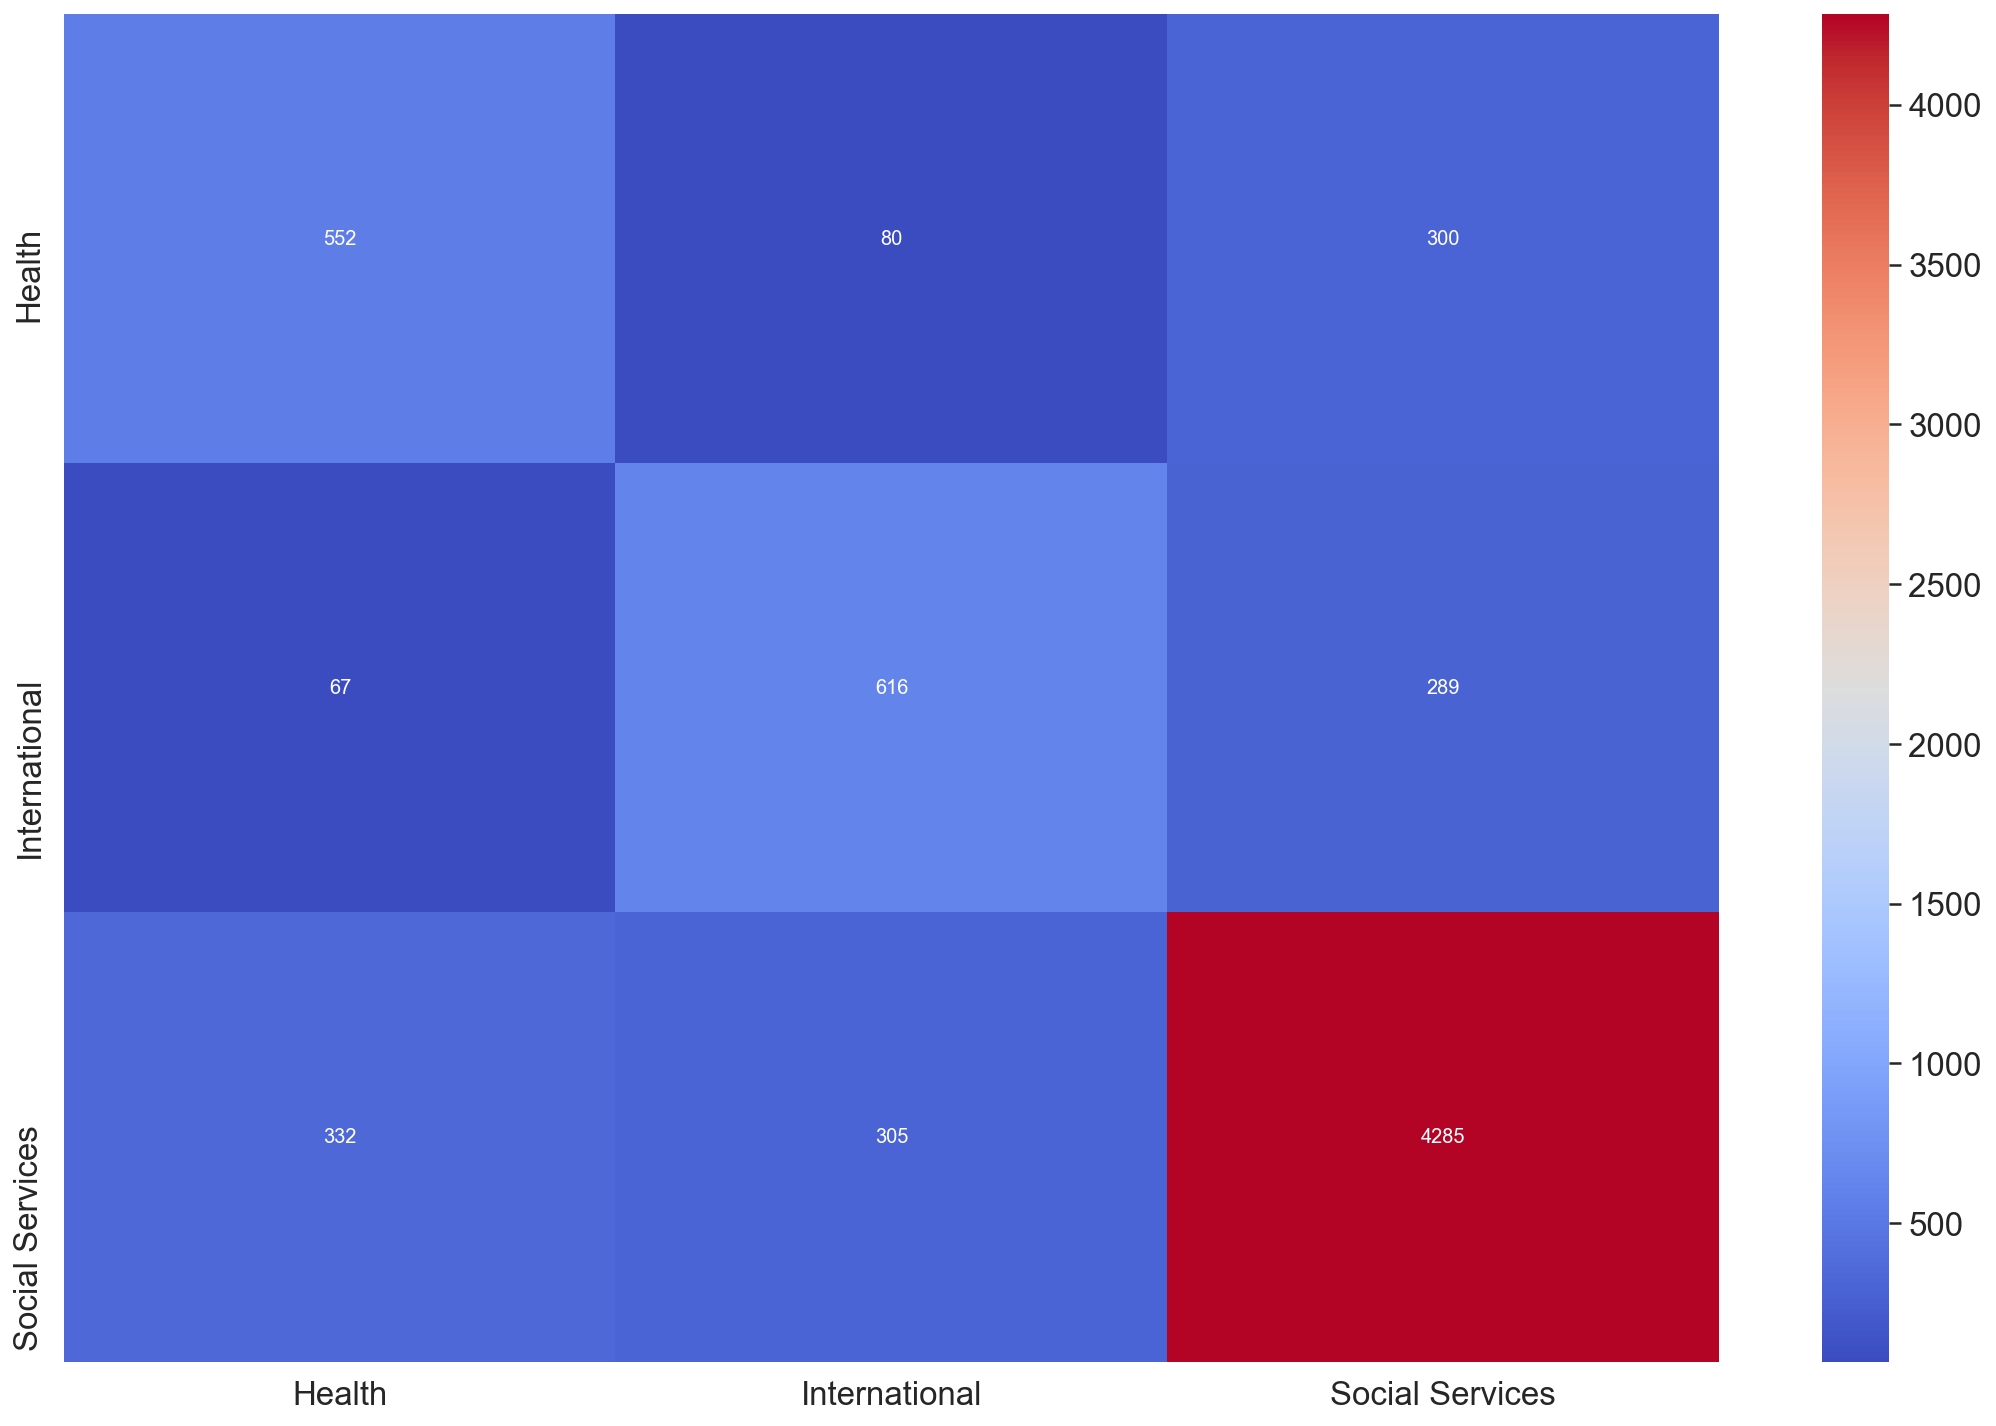

In [25]:
conf_mat = confusion_matrix(y_test, y_preds, labels=log_r.classes_)
plot_confusion_matrix_(conf_mat, log_r.classes_)

In [26]:
print(classification_report(y_test, y_preds))

                 precision    recall  f1-score   support

         Health       0.58      0.59      0.59       932
  International       0.62      0.63      0.62       972
Social Services       0.88      0.87      0.87      4922

       accuracy                           0.80      6826
      macro avg       0.69      0.70      0.70      6826
   weighted avg       0.80      0.80      0.80      6826



In [27]:
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette(
    "husl", len(y_test.unique())))

In [30]:
probabilities = log_r.predict_proba(X_test)

In [31]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

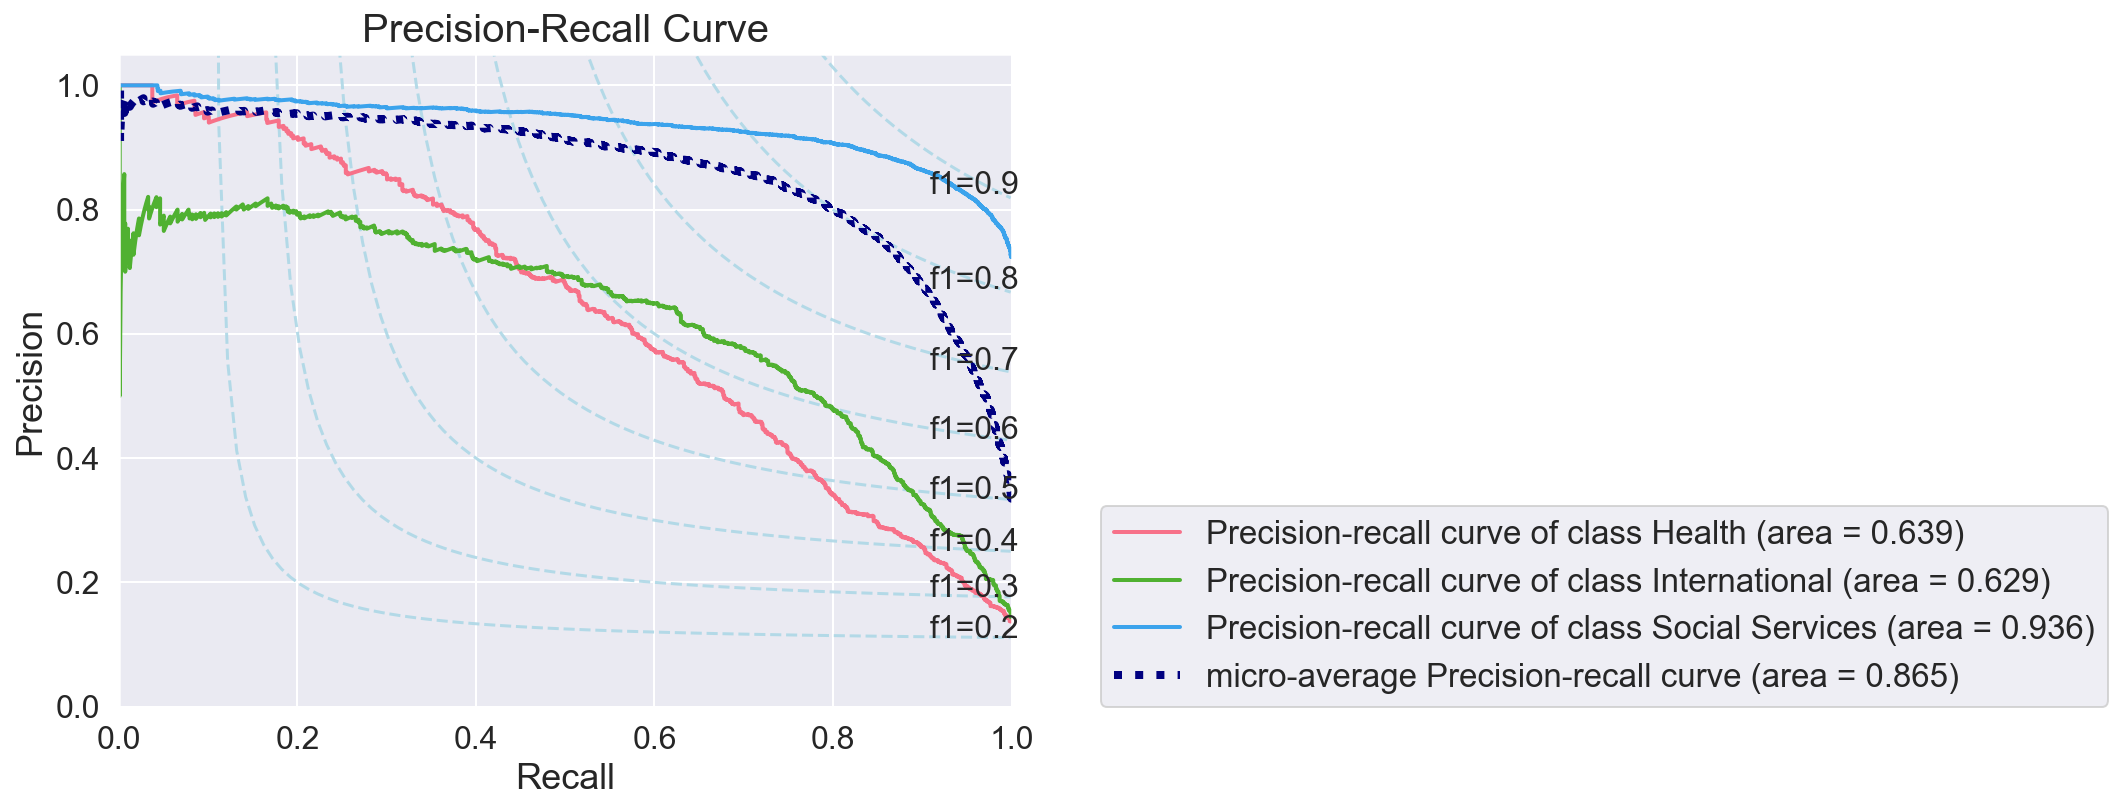

In [32]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, probabilities,
                                    plot_micro=True,
                                    title_fontsize=20, text_fontsize=16,
                                    cmap=cmap,
                                    ax=ax
                                    )

plt.savefig(pj('..','resources','mlp_prec_rec.png'))
ax.legend(loc=[1.1, 0])
plt.show();

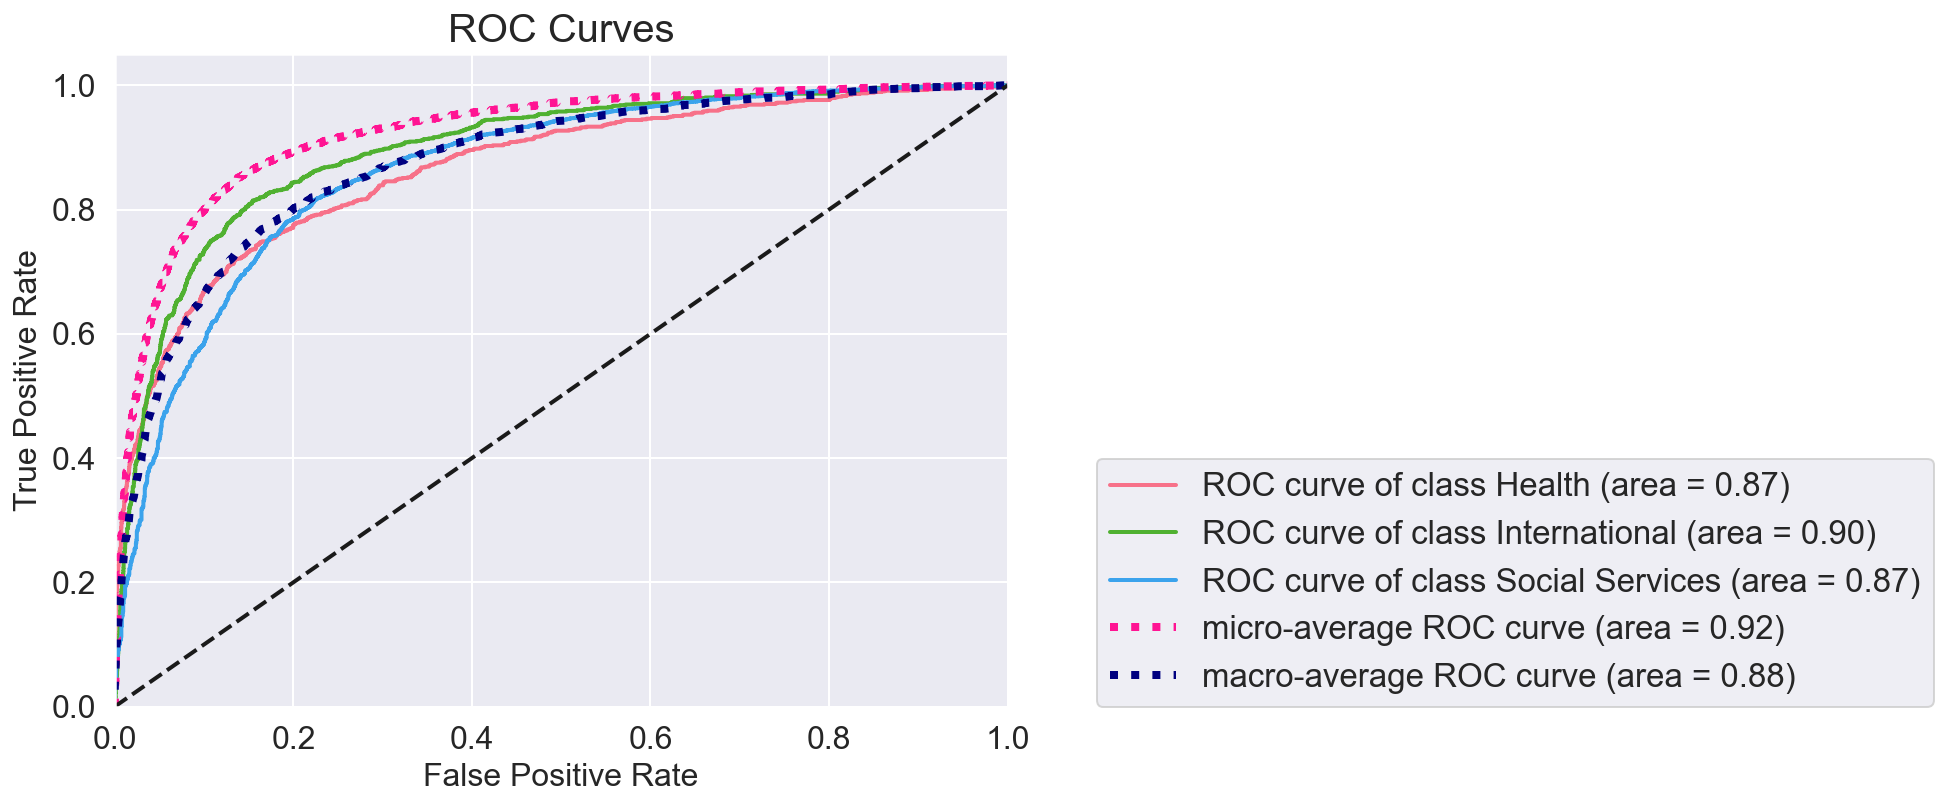

In [33]:
fig, ax = plt.subplots(figsize=(8, 6))
skplt.metrics.plot_roc(y_test, probabilities,
                       plot_micro=True, plot_macro=True,
                       title_fontsize=20, text_fontsize=16,
                       figsize=(8, 6), cmap=cmap, ax=ax)
plt.savefig(pj('..','resources','mlp_roc.png'))
ax.legend(loc=[1.1, 0])
plt.show();